# Inventory Management and Pricing Optimization
## How can we optimize inventory levels to minimize costs while ensuring product availability?


### Loading data

In [ ]:
import pandas as pd
import numpy as np

orders_df = pd.read_csv('../Cleaned_Datasets/orders.csv')
products_df = pd.read_csv('../Cleaned_Datasets/products.csv')
customers_df = pd.read_csv('../Cleaned_Datasets/customers_sg.csv')

### Exploring data

In [128]:
orders_df.head()

order_id           order_time  product_id  customer_id  is_campaign  \
0         1  2019-12-22 08:16:00       15969          299        False   
1         2  2019-12-17 08:05:00       18176          299        False   
2         3  2019-11-08 11:08:00        9272          299        False   
3         4  2019-11-21 20:12:00        8001          299        False   
4         5  2019-11-16 08:13:00       16745          299        False   

   additional_discount campaign_name  
0                  0.0           NaN  
1                  0.0           NaN  
2                  0.0           NaN  
3                  0.0           NaN  
4                  0.0           NaN

In [129]:
products_df.head()

price_ori                               item_category_detail  \
0     8.034430  Shopee | Women's Bags | Shoulder Bags | Should...   
1     1.317273  Shopee | Home Appliances | Sewing Machines | S...   
2     2.647002    Shopee | Women's Bags | Handbags | Set Handbags   
3     2.709284  Shopee | Women Clothes | Maternity Wear | Inne...   
4  1245.336605   Shopee | Cameras & Drones | DSLR Cameras | DSLRs   

                                               title item_rating  \
0  1081 PU SLING BAG KULIT leather Casual Beg Tan...         4.9   
1  Stat Chinese Traditional Frog Buttons Knot Che...         5.0   
2  N09 READY STOCK MYFOOYIN woman handbag set 2in...         4.9   
3  🔥Shocking Sale🔥Cotton Comfort Nursing Bra Brea...         4.9   
4  Canon EOS 70D 18-55mm IS STM Original+64gb+ext...         5.0   

     seller_name  price_actual  total_rating  total_sold  favorite  \
0   qqfwholesale      4.017215         179.0       179.0     128.0   
1  stationery.my      0.700677          17.0        17.0      19.0   
2       fooyin88      2.647002        8100.0      8100.0   21500.0   
3       vivi2002      2.709284        6500.0      6500.0    3400.0   
4    xpro.gadget    852.957480          10.0        10.0     132.0   

                                                desc  Stock Ships_From  \
0  🎉 WELCOME To QQF WHOLESALE \r\n😍 ALL item read...   2906  Singapore   
1  Chinese Traditional Frog Buttons Knot Cheongsa...  31701      China   
2  READY STOCK\nMEASUREMENT:\nLONG 26CM X HEIGHT ...   2044   Malaysia   
3  PRODUCT DESCRIPTION\nMaterial:95%Cotton+5%Span...    386   Malaysia   
4  Canon 70D\nHighlights\nEF-S 18-55mm f/3.5-5.6 ...     36  Singapore   

   product_id     main_category     mid_category  \
0           1      Women's Bags    Shoulder Bags   
1           2   Home Appliances  Sewing Machines   
2           3      Women's Bags         Handbags   
3           4     Women Clothes   Maternity Wear   
4           5  Cameras & Drones     DSLR Cameras   

                      sub_category  
0                    Shoulder Bags  
1  Sewing Machines and Accessories  
2                     Set Handbags  
3                        Innerwear  
4                            DSLRs

In [131]:
customers_df.head()

index  customer_id  subject_line_length last_open_day last_login_day  \
0      0          299                   32            19              1   
1      1         2143                   32            21              2   
2      2         2306                   37           130              1   
3      3         3334                   32             9             13   
4      4         5751                   32            62              2   

  last_checkout_day  open_count_last_10_days  open_count_last_30_days  \
0                 9                        0                        1   
1                 6                        0                        2   
2                 0                        0                        0   
3                15                        1                        1   
4                 2                        0                        0   

   open_count_last_60_days  login_count_last_10_days  ...  open_flag  row_id  \
0                        3                        34  ...          0    2393   
1                        4                        20  ...          0    2429   
2                        0                       172  ...          0    2434   
3                        2                         2  ...          0    2448   
4                        0                        22  ...          0    2486   

   attr_1  attr_2  attr_3   age      domain  gender  \
0     1.0     1.0     1.0  38.0  @gmail.com  Female   
1     1.0     1.0     2.0  26.0  @yahoo.com    Male   
2     1.0     1.0     4.0  56.0  @gmail.com    Male   
3     1.0     1.0     2.0  30.0  @gmail.com  Female   
4     1.0     1.0     2.0  27.0  @yahoo.com  Female   

   checkout_count_last_6_months  checkout_count_last_1_year  
0                            21                          32  
1                            27                          75  
2                            57                         104  
3                             6                          15  
4                            56                         100  

[5 rows x 25 columns]

### Generating necessary data

In [132]:
# Initialize restock thresholds and percentages in products_df
np.random.seed(0)
products_df['restock_threshold'] = np.random.randint(5, 15, size=len(products_df))
products_df['restock_percentage'] = np.random.uniform(0.15, 0.3, size=len(products_df))

def randomize_missing_ratings(df, column='item_rating', min_rating=3.0, max_rating=5.0):
    # Fill missing ratings with random values within the specified range
    no_rating = 'No ratings yet'
    df.loc[df[column] == no_rating, column] = np.random.uniform(min_rating, max_rating, size=df[df[column] == no_rating].shape[0])
    df[column] = pd.to_numeric(df[column], errors='coerce')
    df.loc[pd.isnull(df[column]), column] = np.random.uniform(min_rating, max_rating, size=df[pd.isnull(df[column])].shape[0])
    return df

products_df = randomize_missing_ratings(products_df)

products_df['seller_rating'] = products_df.groupby('seller_name')['item_rating'].transform('mean')

def generate_seller_response_time(df):
    def response_time_by_rating(seller_rating):
        if seller_rating >= 5.0:
            return np.random.uniform(0.01, 0.5)
        elif seller_rating >= 4.9:
            return np.random.uniform(0.05, 1)
        elif seller_rating >= 4.8:
            return np.random.uniform(0.3, 2)
        elif seller_rating >= 4.7:
            return np.random.uniform(0.5, 4)
        elif seller_rating >= 4.6:
            return np.random.uniform(0.8, 8)
        elif seller_rating >= 4.5:
            return np.random.uniform(1, 16)
        elif seller_rating >= 4.4:
            return np.random.uniform(1.2, 32)
        elif seller_rating >= 4.3:
            return np.random.uniform(2.4, 35)
        elif seller_rating >= 4.2:
            return np.random.uniform(4.8, 38)
        elif seller_rating >= 4.1:
            return np.random.uniform(5, 40)
        elif seller_rating >= 4.0:
            return np.random.uniform(6, 50)
        else:
            return np.random.uniform(10, 80)

    # Apply the above function 'response_time_by_rating' to the dataset
    df['seller_response_time'] = df['seller_rating'].apply(response_time_by_rating)

    # Introduce noise and outliers/anomalies
    for seller in df['seller_name'].unique():
        # we set a 5% chance for each seller to be an outlier
        if np.random.rand() < 0.05:
            df.loc[df['seller_name'] == seller, 'seller_response_time'] = df.loc[
                df['seller_name'] == seller, 'seller_response_time'
            ].apply(lambda x: x * np.random.uniform(0.2, 10))  # Multiply response time by a random factor

    return df

# We apply the above 'generate_seller_response_time' function to our dataset
products_df = generate_seller_response_time(products_df)

# Define cost and lead time ranges by `main_category` and `Ships_From`
production_cost_percentages = {
    'Health & Beauty': (0.05, 0.1), 'Men Clothes': (0.08, 0.15), 'Women Clothes': (0.08, 0.15),
    'Mobile & Accessories': (0.1, 0.2), 'Baby & Toys': (0.07, 0.12), 'Home & Living': (0.08, 0.15),
    'Groceries & Pets': (0.05, 0.1), 'Home Appliances': (0.1, 0.25), 'Automotive': (0.1, 0.25),
    'Sports & Outdoor': (0.1, 0.2), 'Women\'s Bags': (0.08, 0.18), 'Watches': (0.1, 0.2),
    'Men\'s Bags & Wallets': (0.08, 0.15), 'Cameras & Drones': (0.15, 0.3), 'Women Shoes': (0.08, 0.2),
    'Muslim Fashion': (0.07, 0.15), 'Fashion Accessories': (0.05, 0.1), 'Computer & Accessories': (0.1, 0.25),
    'Games, Books & Hobbies': (0.08, 0.12), 'Men Shoes': (0.08, 0.15), 'Travel & Luggage': (0.1, 0.2),
    'Gaming & Consoles': (0.12, 0.25), 'Tickets & Vouchers': (0.05, 0.08), 'Others': (0.08, 0.15)
}

holding_cost_percentage_range = (0.02, 0.05)  # Holding cost as a random percentage of price_actual

lead_time_ranges = {
    "Singapore": (1.0, 3.0), "Malaysia": (3.0, 8.0), "Indonesia": (5.0, 12.0), "Thailand": (5.0, 12.0),
    "Vietnam": (7.0, 15.0), "China": (10.0, 25.0), "Taiwan": (8.0, 20.0), "South Korea": (7.0, 18.0)
}

# Calculate cost_to_produce as a random percentage of `price_actual` based on `main_category`
products_df['cost_to_produce'] = products_df.apply(
    lambda row: row['price_actual'] * np.random.uniform(
        *production_cost_percentages.get(row['main_category'], (0.1, 0.2))
    ), axis=1
)

# Calculate holding_cost as a random percentage of `price_actual`
products_df['holding_cost'] = products_df['price_actual'] * np.random.uniform(*holding_cost_percentage_range)

# Calculate lead_time based on `Ships_From` with four decimal places
products_df['lead_time'] = products_df['Ships_From'].apply(
    lambda x: round(np.random.uniform(*lead_time_ranges.get(x, (5.0, 20.0))), 4)
)

# Merge dataframes and convert 'order_time' to datetime
merged_df = pd.merge(orders_df, products_df, on='product_id', how='left')
merged_df['order_time'] = pd.to_datetime(merged_df['order_time'], errors='coerce')
merged_df.dropna(subset=['order_time'], inplace=True)

# Sort by order time for sequential processing
merged_df.sort_values(by='order_time', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Add a 'date' column and extract day-of-week, month, and weekend flag for seasonality
merged_df['date'] = merged_df['order_time'].dt.date
merged_df['day_of_week'] = merged_df['order_time'].dt.dayofweek
merged_df['is_weekend'] = merged_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
merged_df['month'] = merged_df['order_time'].dt.month

# Initialize discount and engagement features
merged_df['is_discount'] = merged_df['price_actual'] < merged_df['price_ori']
merged_df['discount_percentage'] = np.where(
    merged_df['is_discount'],
    ((merged_df['price_ori'] - merged_df['price_actual']) / merged_df['price_ori']) * 100,
    0
)

def generate_delivery_time(df):

    # Function that takes in the item_rating and outputs a random number from a set range corresponding to that specific item's rating
    # For example, an item rating of 5 stars would mean that the item takes about 1-3 days to be delivered to the customer
    def delivery_time_by_rating(item_rating):
        if item_rating >= 5.0:
            return np.random.uniform(1, 3)
        elif item_rating >= 4.9:
            return np.random.uniform(1, 3.5)
        elif item_rating >= 4.8:
            return np.random.uniform(1.5, 4)
        elif item_rating >= 4.7:
            return np.random.uniform(1.5, 4.5)
        elif item_rating >= 4.6:
            return np.random.uniform(2, 5)
        elif item_rating >= 4.5:
            return np.random.uniform(2, 5.5)
        elif item_rating >= 4.4:
            return np.random.uniform(2.5, 6)
        elif item_rating >= 4.3:
            return np.random.uniform(2.5, 6.5)
        elif item_rating >= 4.2:
            return np.random.uniform(3, 7)
        elif item_rating >= 4.1:
            return np.random.uniform(3, 7.5)
        elif item_rating >= 4.0:
            return np.random.uniform(3.5, 8)
        else:
            return np.random.uniform(7, 21)

    # We apply the above function 'delivery_time_by_rating' to each row of our dataset
    df['delivery_time'] = df['item_rating'].apply(delivery_time_by_rating)


    for seller in df['seller_name'].unique():
        # we set a 5% chance for each seller to be an outlier
        if np.random.rand() < 0.05:
            df.loc[df['seller_name'] == seller, 'delivery_time'] = df.loc[
                df['seller_name'] == seller, 'delivery_time'
            ].apply(lambda x: x * np.random.uniform(0.5, 3))  # Multiply delivery time by a random factor

    # Adding additional delivery time in days based on ship_from column
    def add_delivery_time_by_ship_from(ship_from):
        if ship_from == 'China':
            return np.random.uniform(7, 14)
        elif ship_from == 'Indonesia':
            return np.random.uniform(2, 5)
        elif ship_from == 'Malaysia':
            return np.random.uniform(1, 3)
        elif ship_from == 'South Korea':
            return np.random.uniform(5, 10)
        elif ship_from == 'Taiwan':
            return np.random.uniform(5, 9)
        elif ship_from == 'Thailand':
            return np.random.uniform(3, 6)
        elif ship_from == 'Vietnam':
            return np.random.uniform(4, 7)

    # Applying the above functions to the dataset
    df['additional_delivery_time'] = df['Ships_From'].apply(add_delivery_time_by_ship_from)
    df['delivery_time'] = df['delivery_time'] + df['additional_delivery_time']

    return df

# We apply the above 'generate_delivery_time' function to our 2 datasets
merged_df = generate_delivery_time(merged_df)




In [133]:
merged_df.columns

Index(['order_id', 'order_time', 'product_id', 'customer_id', 'is_campaign',
       'additional_discount', 'campaign_name', 'price_ori',
       'item_category_detail', 'title', 'item_rating', 'seller_name',
       'price_actual', 'total_rating', 'total_sold', 'favorite', 'desc',
       'Stock', 'Ships_From', 'main_category', 'mid_category', 'sub_category',
       'restock_threshold', 'restock_percentage', 'seller_rating',
       'seller_response_time', 'cost_to_produce', 'holding_cost', 'lead_time',
       'date', 'day_of_week', 'is_weekend', 'month', 'is_discount',
       'discount_percentage', 'delivery_time', 'additional_delivery_time'],
      dtype='object')

In [134]:
# Ensure numerical columns are converted to numeric types
numeric_columns = [
       'additional_discount', 'price_ori', 'item_rating',
       'price_actual', 'total_rating', 'total_sold', 'favorite', 'Stock',
       'restock_threshold', 'restock_percentage', 'seller_rating',
       'seller_response_time', 'cost_to_produce', 'holding_cost', 'lead_time',
       'date', 'day_of_week', 'month',
       'discount_percentage', 'delivery_time', 'additional_delivery_time'
]

for col in numeric_columns:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Initialize running cumulative totals for each product
product_cumulative = {
    product_id: {
        'total_sold': row['total_sold'],
        'total_rating': row['total_rating'],
        'Stock': row['Stock']
    }
    for product_id, row in products_df.set_index('product_id').iterrows()
}

In [ ]:
# Update cumulative values for each row without looping for daily sales
for i, row in merged_df.iterrows():
    product_id = row['product_id']
    customer_id = row['customer_id']


    # Update cumulative total_sold and total_rating
    product_cumulative[product_id]['total_sold'] += 1
    product_cumulative[product_id]['total_rating'] += 1

    # Update Stock and check if restocking is needed
    product_cumulative[product_id]['Stock'] -= 1
    if product_cumulative[product_id]['Stock'] < row['restock_threshold']:
        product_cumulative[product_id]['Stock'] += int(product_cumulative[product_id]['Stock'] * row['restock_percentage'])


    # Update the current row in merged_df with cumulative values
    merged_df.at[i, 'total_sold'] = product_cumulative[product_id]['total_sold']
    merged_df.at[i, 'total_rating'] = product_cumulative[product_id]['total_rating']
    merged_df.at[i, 'Stock'] = product_cumulative[product_id]['Stock']

In [135]:
merged_df.columns

Index(['order_id', 'order_time', 'product_id', 'customer_id', 'is_campaign',
       'additional_discount', 'campaign_name', 'price_ori',
       'item_category_detail', 'title', 'item_rating', 'seller_name',
       'price_actual', 'total_rating', 'total_sold', 'favorite', 'desc',
       'Stock', 'Ships_From', 'main_category', 'mid_category', 'sub_category',
       'restock_threshold', 'restock_percentage', 'seller_rating',
       'seller_response_time', 'cost_to_produce', 'holding_cost', 'lead_time',
       'date', 'day_of_week', 'is_weekend', 'month', 'is_discount',
       'discount_percentage', 'delivery_time', 'additional_delivery_time'],
      dtype='object')

In [140]:
daily_aggregated_df = (
    merged_df
    .set_index('order_time')
    .groupby('sub_category')
    .resample('D')
    .agg({
        'price_ori': 'mean',
        'price_actual': 'mean',
        'additional_discount': 'mean',
        'day_of_week': 'first',
        'is_weekend': 'first',
        'is_discount': lambda x: (x.mean() * 100),
        'is_campaign': lambda x: (x.mean() * 100),
        'campaign_name': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
        'discount_percentage': 'mean',
        'product_id': 'size'
    })
    .rename(columns={
        'price_ori': 'avg_original_price',
        'price_actual': 'avg_discounted_price',
        'additional_discount': 'avg_additional_discount',
        'day_of_week': 'day_of_week',
        'is_weekend': 'is_weekend',
        'is_discount': 'products_discounted_percentage',
        'is_campaign': 'campaign_percentage',
        'campaign_name': 'campaign',
        'discount_percentage': 'avg_discount_percentage',
        'product_id': 'daily_sales'
    })
    .reset_index()
)


In [141]:
daily_aggregated_df.columns

Index(['sub_category', 'order_time', 'avg_original_price',
       'avg_discounted_price', 'avg_additional_discount', 'day_of_week',
       'is_weekend', 'products_discounted_percentage', 'campaign_percentage',
       'campaign', 'avg_discount_percentage', 'daily_sales'],
      dtype='object')

In [142]:
daily_aggregated_df.head()

sub_category order_time  avg_original_price  avg_discounted_price  \
0  Abdominal Binder 2019-01-05            3.082979              0.744275   
1  Abdominal Binder 2019-01-06                 NaN                   NaN   
2  Abdominal Binder 2019-01-07                 NaN                   NaN   
3  Abdominal Binder 2019-01-08                 NaN                   NaN   
4  Abdominal Binder 2019-01-09                 NaN                   NaN   

   avg_additional_discount  day_of_week  is_weekend  \
0                      0.0          5.0         1.0   
1                      NaN          NaN         NaN   
2                      NaN          NaN         NaN   
3                      NaN          NaN         NaN   
4                      NaN          NaN         NaN   

   products_discounted_percentage  campaign_percentage campaign  \
0                           100.0                  0.0     None   
1                             NaN                  NaN     None   
2                             NaN                  NaN     None   
3                             NaN                  NaN     None   
4                             NaN                  NaN     None   

   avg_discount_percentage  daily_sales  
0                75.858586            1  
1                      NaN            0  
2                      NaN            0  
3                      NaN            0  
4                      NaN            0

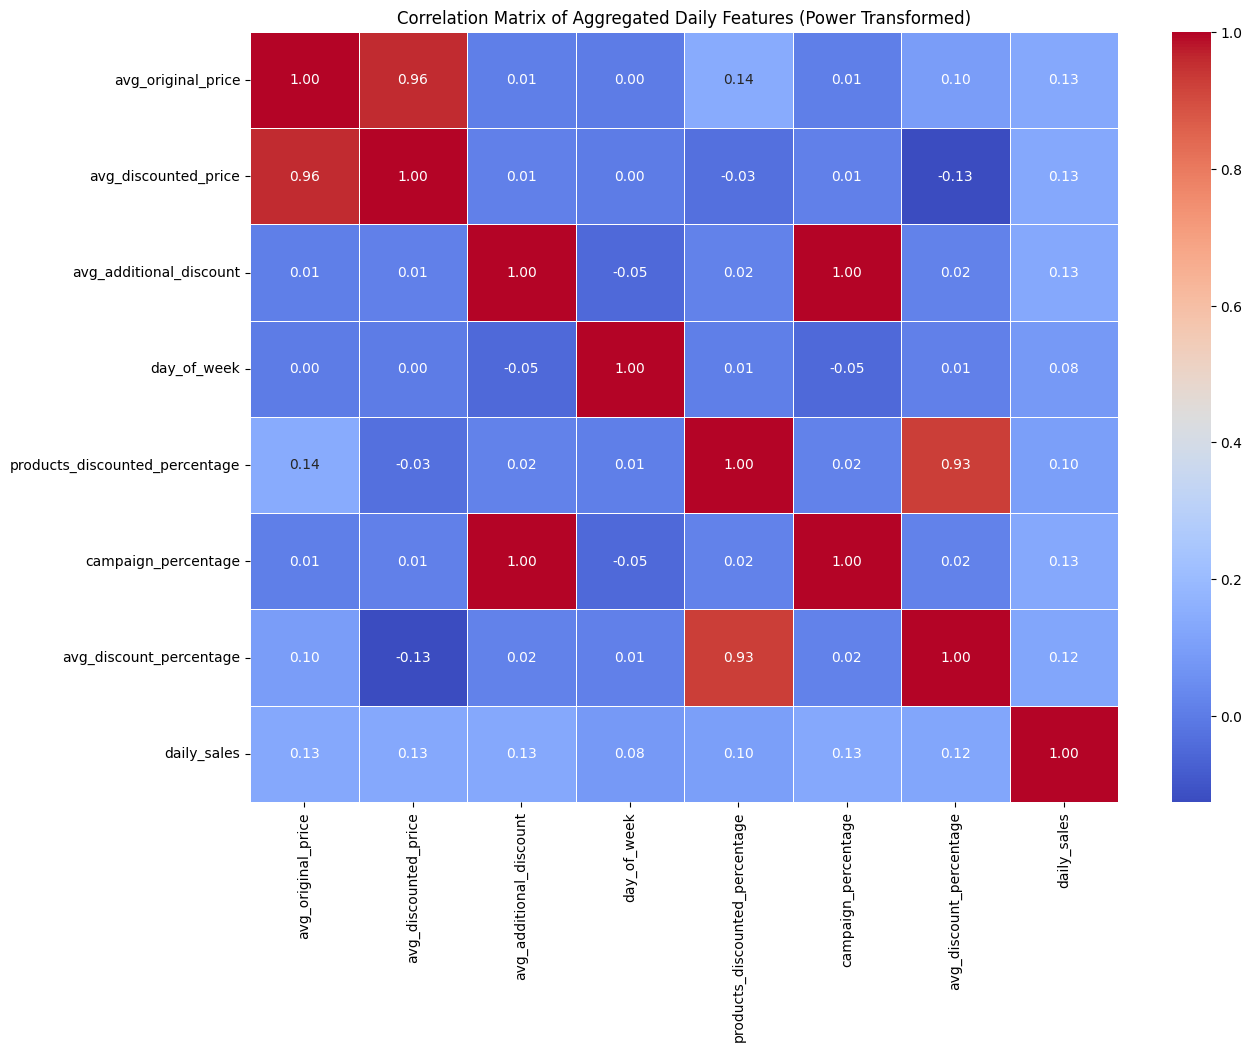

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer

# Assuming 'daily_aggregated_df' is the dataframe containing the daily aggregated data

# Define the numeric columns to transform
numeric_columns = [
    'avg_original_price',
       'avg_discounted_price', 'avg_additional_discount', 'day_of_week',
       'products_discounted_percentage', 'campaign_percentage',
       'avg_discount_percentage', 'daily_sales']

# Filter to include only numeric columns for transformation
df_numeric = daily_aggregated_df[numeric_columns].copy()

# Apply Power Transformer
pt = PowerTransformer(method='yeo-johnson', standardize=True)
df_transformed = pd.DataFrame(pt.fit_transform(df_numeric), columns=numeric_columns)

# Calculate the correlation matrix on the transformed data
correlation_matrix = df_transformed.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Aggregated Daily Features (Power Transformed)")
plt.show()


In [155]:
# Redefine top_cats based on most common sub-categories in merged_df
top_categories = merged_df['sub_category'].value_counts()
print(top_categories)

sub_category
Others                      16321
Android Tablets               969
Occupational Attire           865
Business & Casual Shirts      839
Polo Shirts                   785
                            ...  
Pads & Covers                   2
Yogurt Drinks                   2
Local Attractions               1
Pet Home & Travel               1
Ink                             1
Name: count, Length: 872, dtype: int64


In [158]:
top_three = top_categories.index[1:4]
print(f"Top three most purchased categories based on sub-category frequency: {top_three[0]}, {top_three[1]}, {top_three[2]}")

Top three most purchased categories based on sub-category frequency: Android Tablets, Occupational Attire, Business & Casual Shirts


In [160]:
numeric_columns

['avg_original_price',
 'avg_discounted_price',
 'avg_additional_discount',
 'day_of_week',
 'products_discounted_percentage',
 'campaign_percentage',
 'avg_discount_percentage',
 'daily_sales']


Sub-Category: Android Tablets
Correlation with Daily Sales:
daily_sales                       1.000000
avg_additional_discount           0.546130
campaign_percentage               0.545211
avg_original_price                0.152730
avg_discounted_price              0.147862
products_discounted_percentage   -0.082111
avg_discount_percentage          -0.098421
Name: daily_sales, dtype: float64


C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_17556\1165220191.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(columns_to_plot) - 1)  # Use 'tab10' for diverse colors


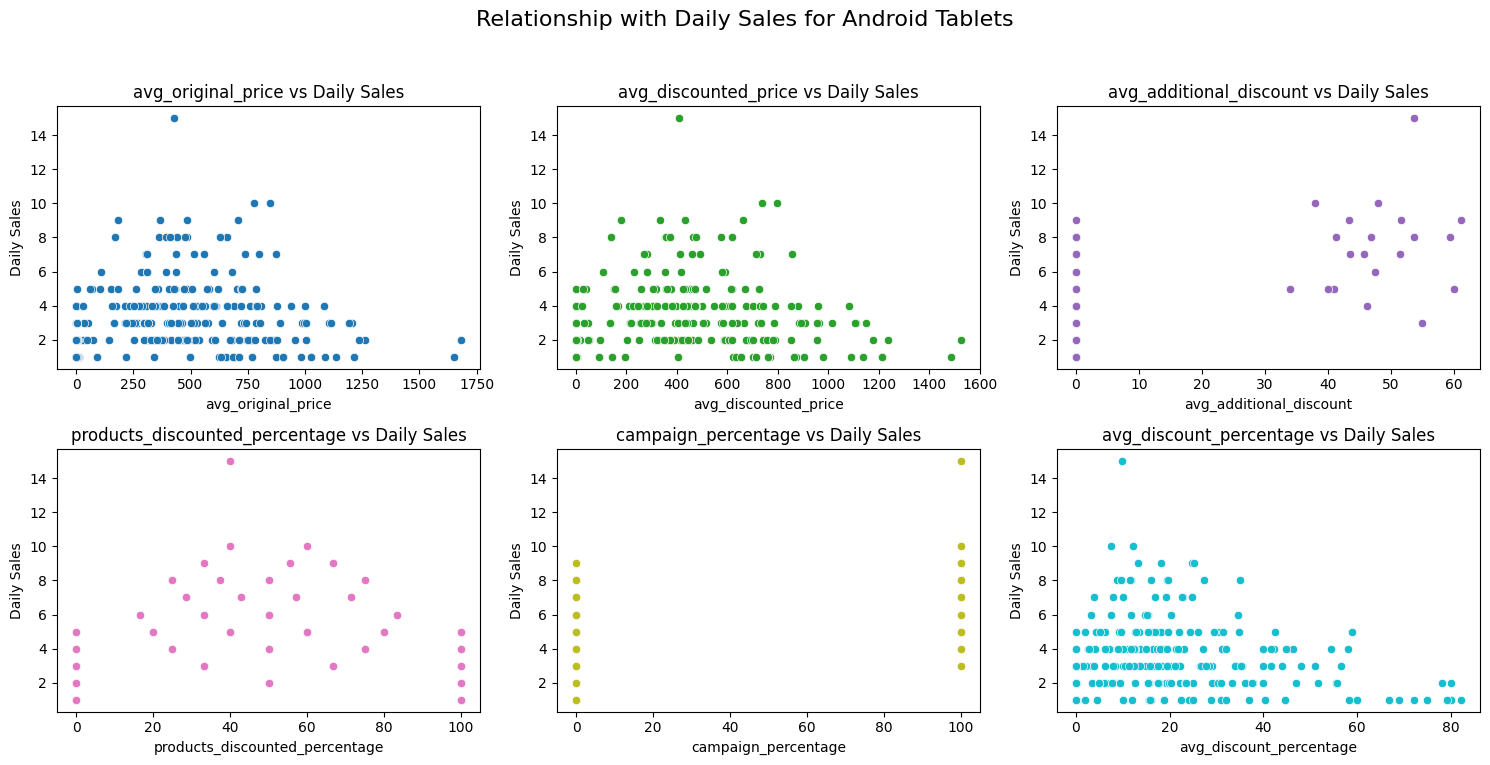


Sub-Category: Occupational Attire
Correlation with Daily Sales:
daily_sales                       1.000000
campaign_percentage               0.498661
avg_additional_discount           0.471386
avg_discounted_price              0.005826
avg_original_price                0.005658
avg_discount_percentage           0.004242
products_discounted_percentage   -0.004081
Name: daily_sales, dtype: float64


C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_17556\1165220191.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(columns_to_plot) - 1)  # Use 'tab10' for diverse colors


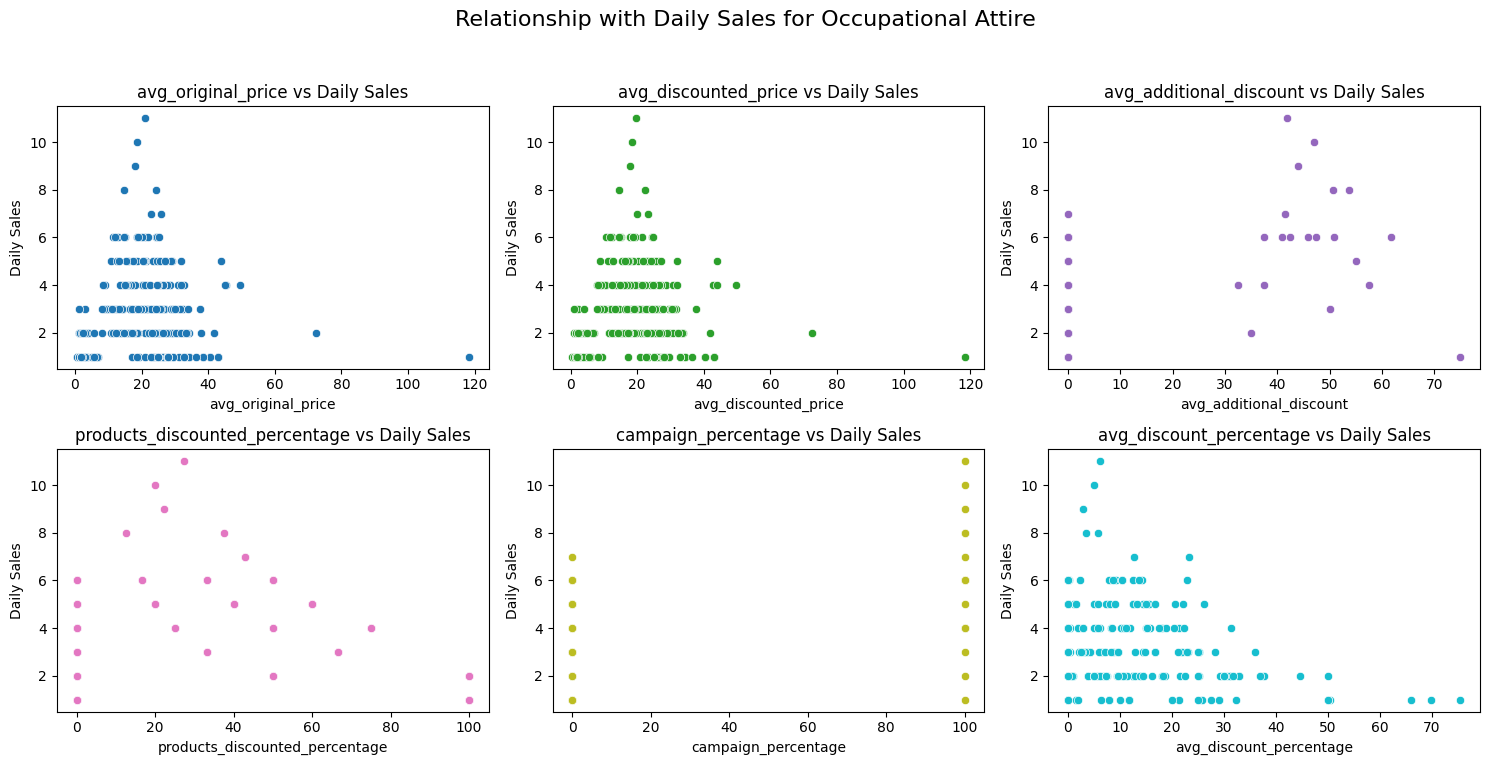


Sub-Category: Business & Casual Shirts
Correlation with Daily Sales:
daily_sales                       1.000000
campaign_percentage               0.403294
avg_additional_discount           0.392966
avg_discounted_price             -0.017128
avg_original_price               -0.027352
avg_discount_percentage          -0.053733
products_discounted_percentage   -0.053861
Name: daily_sales, dtype: float64


C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_17556\1165220191.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(columns_to_plot) - 1)  # Use 'tab10' for diverse colors


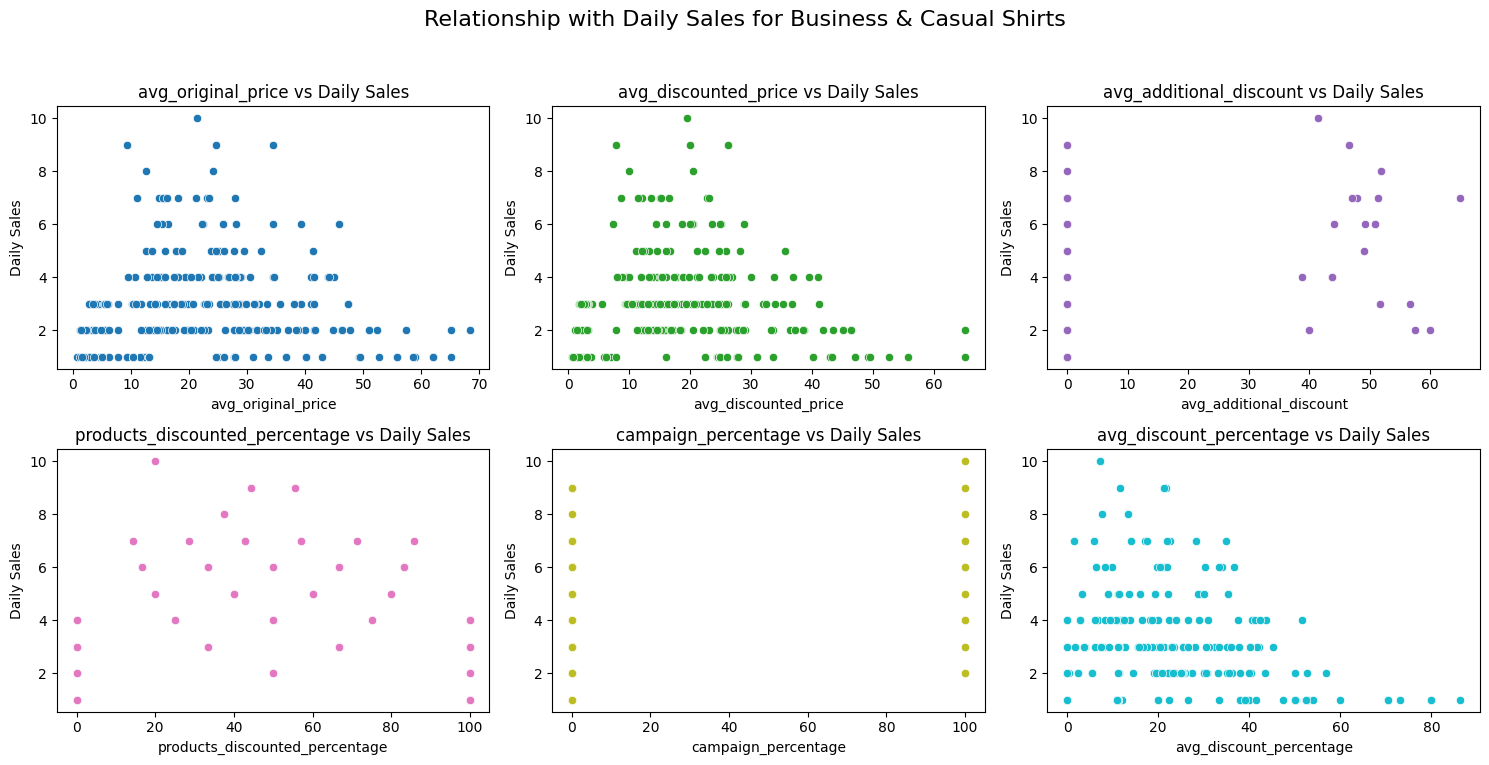

In [163]:
import matplotlib.cm as cm

# Loop over each sub-category in top_three
for sub_category in top_three:
    print(f"\nSub-Category: {sub_category}")
    
    # Filter data for the current sub-category
    sub_cat_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == sub_category].copy()

    # Calculate correlations
    columns_to_plot = [
        'avg_original_price',
        'avg_discounted_price',
        'avg_additional_discount',
        'products_discounted_percentage',
        'campaign_percentage',
        'avg_discount_percentage',
        'daily_sales'
    ]
    
    correlation_matrix = sub_cat_df[columns_to_plot].corr()
    print("Correlation with Daily Sales:")
    print(correlation_matrix['daily_sales'].sort_values(ascending=False))

    # Plot each column against daily_sales
    num_cols = 3
    num_rows = (len(columns_to_plot) - 1 + num_cols - 1) // num_cols  # Exclude 'daily_sales' itself
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))
    axes = axes.flatten()
    fig.suptitle(f"Relationship with Daily Sales for {sub_category}", fontsize=16)

    # Set up color map
    colors = cm.get_cmap('tab10', len(columns_to_plot) - 1)  # Use 'tab10' for diverse colors

    for i, col in enumerate(columns_to_plot):
        if col == 'daily_sales':
            continue  # Skip self-correlation with daily_sales
        sns.scatterplot(
            x=sub_cat_df[col],
            y=sub_cat_df['daily_sales'],
            ax=axes[i],
            color=colors(i)
        )
        axes[i].set_title(f"{col} vs Daily Sales")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Daily Sales")

    # Remove any unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



Sub-Category: Android Tablets


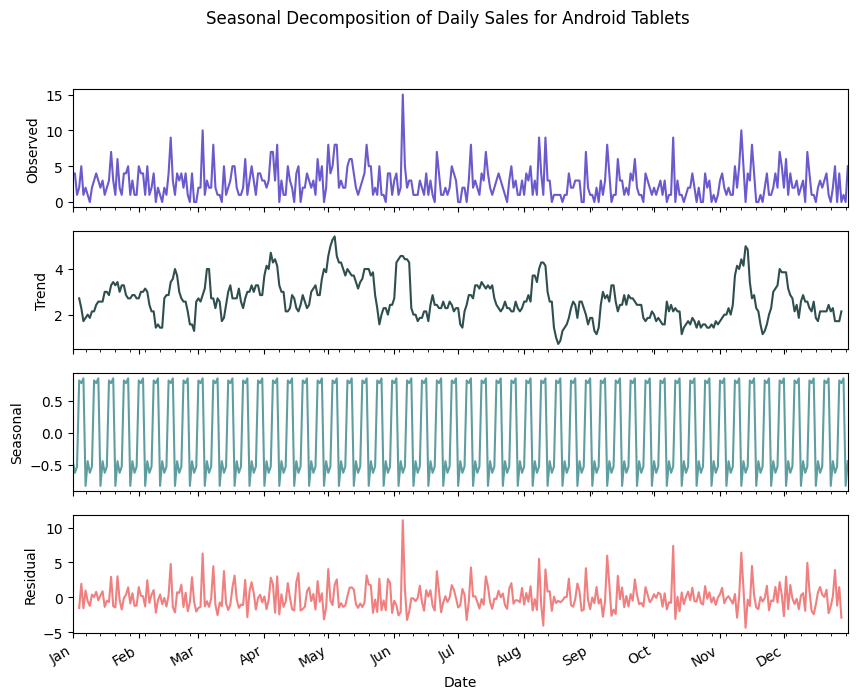

ADF Statistic: -17.24
p-value: 0.00
Critical Value 1%: -3.448
Critical Value 5%: -2.870
Critical Value 10%: -2.571
The series is stationary.

Sub-Category: Occupational Attire


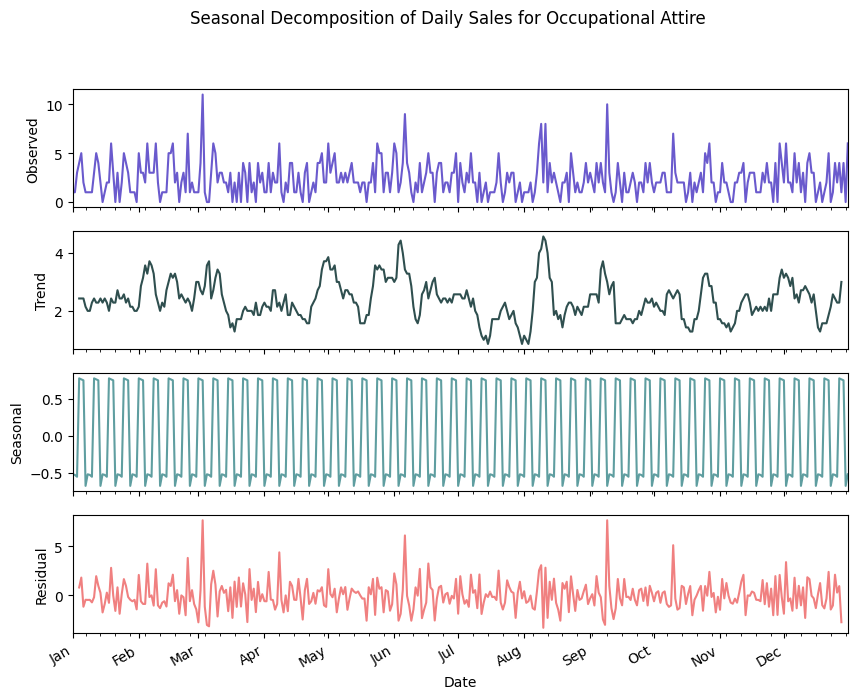

ADF Statistic: -12.11
p-value: 0.00
Critical Value 1%: -3.449
Critical Value 5%: -2.870
Critical Value 10%: -2.571
The series is stationary.

Sub-Category: Business & Casual Shirts


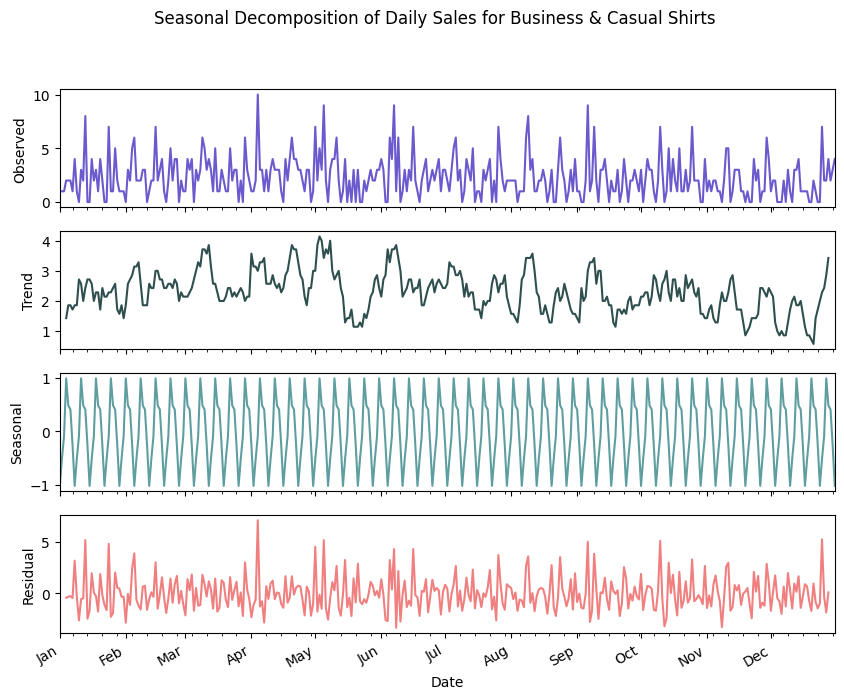

ADF Statistic: -18.04
p-value: 0.00
Critical Value 1%: -3.448
Critical Value 5%: -2.870
Critical Value 10%: -2.571
The series is stationary.


In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.dates as mdates

# Time Series Analysis on Daily Aggregated Data
for sub_category in top_three:
    print(f"\nSub-Category: {sub_category}")

    # Filter data for the current sub-category and set order_time as the index
    sub_cat_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == sub_category].copy()
    sub_cat_df.set_index('order_time', inplace=True)

    # ----- 1. Seasonal Decomposition -----
    # Decomposing daily sales time series
    decomposed = seasonal_decompose(sub_cat_df['daily_sales'], model='additive', period=7)

    # Plot decomposition results with custom x-axis for months
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    decomposed.observed.plot(ax=ax1, legend=False, color='slateblue')
    ax1.set_ylabel("Observed")
    decomposed.trend.plot(ax=ax2, legend=False, color='darkslategray')
    ax2.set_ylabel("Trend")
    decomposed.seasonal.plot(ax=ax3, legend=False, color='cadetblue')
    ax3.set_ylabel("Seasonal")
    decomposed.resid.plot(ax=ax4, legend=False, color='lightcoral')
    ax4.set_ylabel("Residual")

    # Set x-axis to display months only
    ax4.set_xlabel("Date")
    ax4.xaxis.set_major_locator(mdates.MonthLocator())  # Place ticks at the start of each month
    ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Format as abbreviated month only
    fig.autofmt_xdate()  # Rotate date labels for better readability

    plt.suptitle(f"Seasonal Decomposition of Daily Sales for {sub_category}")
    plt.show()

    # ----- 2. Stationarity Test -----
    # Perform Augmented Dickey-Fuller test on daily sales
    adf_result = adfuller(sub_cat_df['daily_sales'].dropna())
    print(f"ADF Statistic: {adf_result[0]:.2f}")
    print(f"p-value: {adf_result[1]:.2f}")
    for key, value in adf_result[4].items():
        print(f'Critical Value {key}: {value:.3f}')
    if adf_result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is non-stationary.")



Sub-Category: Android Tablets


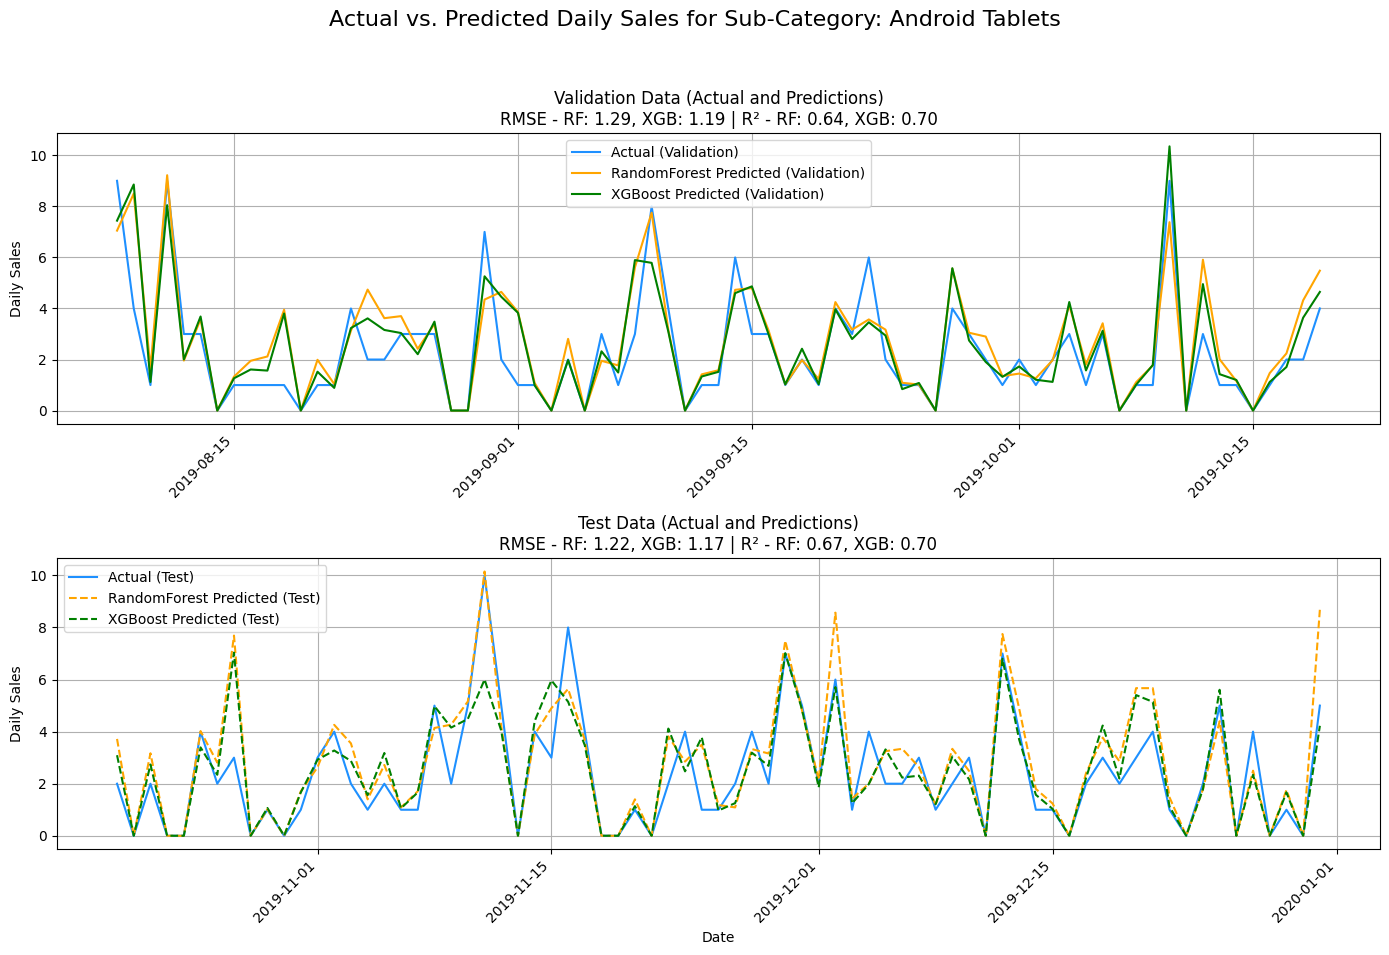


Sub-Category: Occupational Attire


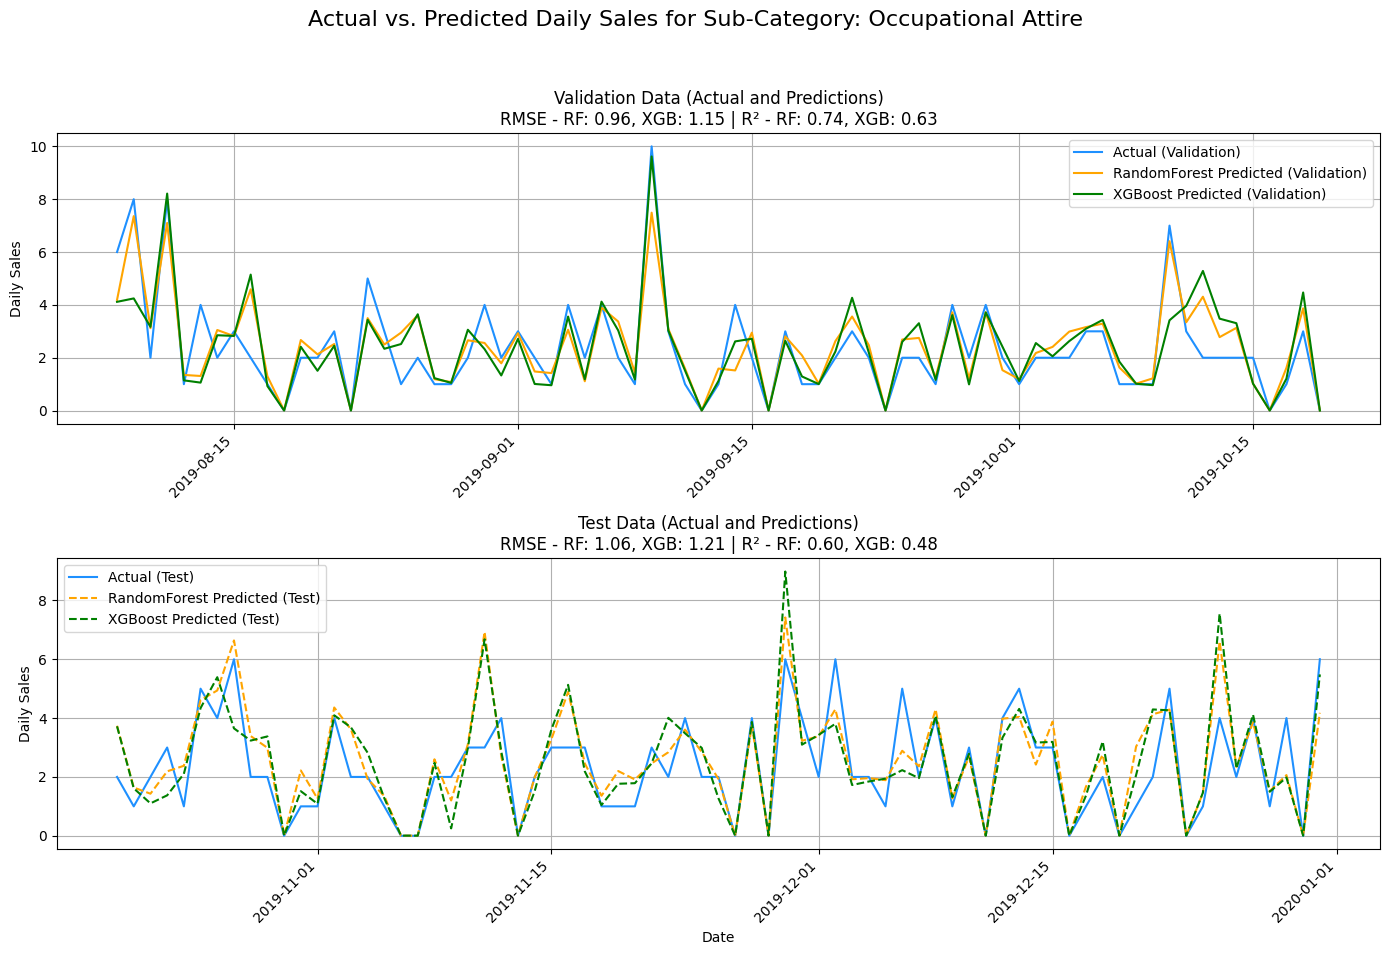


Sub-Category: Business & Casual Shirts


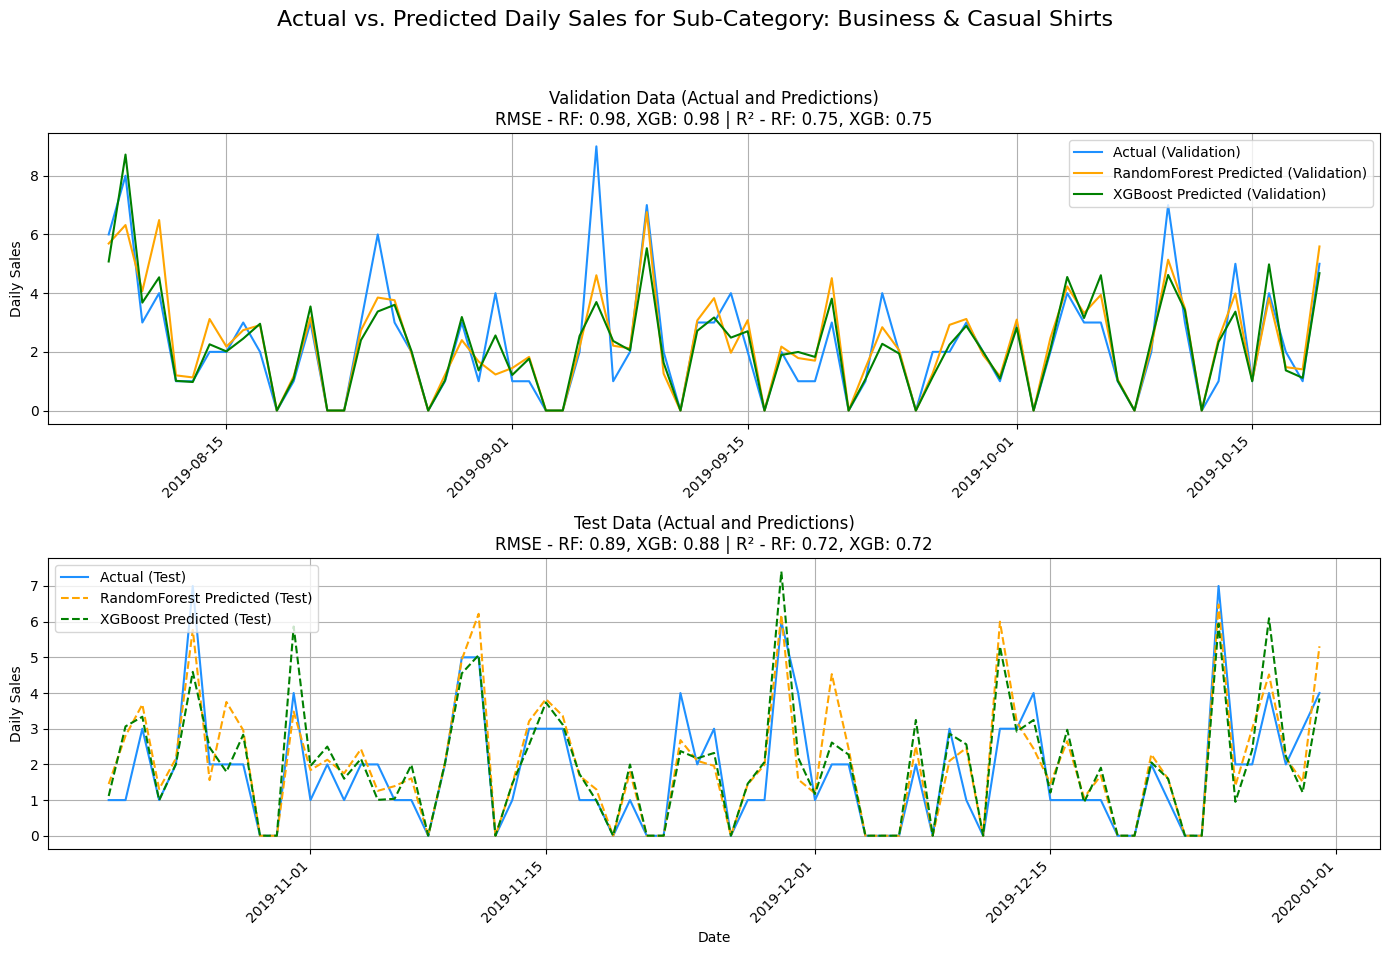

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Define the features to use
features = numeric_columns.copy()
features.remove('daily_sales')

# Loop through each top sub-category
for sub_category in top_three:
    print(f"\nSub-Category: {sub_category}")
    # Filter data for the current sub-category and limit to January-October data
    sub_cat_df = daily_aggregated_df[(daily_aggregated_df['sub_category'] == sub_category) &
                                     (daily_aggregated_df['order_time'] < '2024-11-01')]

    # Define the features and target, and add 'order_time' for date-based indexing
    X = sub_cat_df[features]
    y = sub_cat_df['daily_sales']
    order_time = sub_cat_df['order_time']  # Keep the 'order_time' for plotting

    # Split data into training, validation, and test sets based on `order_time`
    X_train_full, X_test, y_train_full, y_test, train_time_full, test_time = train_test_split(
        X, y, order_time, test_size=0.2, shuffle=False)
    X_train, X_valid, y_train, y_valid, train_time, valid_time = train_test_split(
        X_train_full, y_train_full, train_time_full, test_size=0.25, shuffle=False)  # 60% train, 20% valid, 20% test

    # Define models
    models = {
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=0),
        'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
    }

    # Store predictions and metrics for each model
    predictions = {}
    metrics = {}
    for name, model in models.items():
        model.fit(X_train, y_train)

        # Predictions for validation and test
        y_valid_pred = model.predict(X_valid)
        y_test_pred = model.predict(X_test)
        predictions[name] = (y_valid_pred, y_test_pred)

        # Calculate metrics for validation and test
        metrics[name] = {
            'valid': {
                'r2': r2_score(y_valid, y_valid_pred),
                'rmse': np.sqrt(mean_squared_error(y_valid, y_valid_pred))
            },
            'test': {
                'r2': r2_score(y_test, y_test_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
            }
        }

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle(f"Actual vs. Predicted Daily Sales for Sub-Category: {sub_category}", fontsize=16)

    # 1. Validation Data (Actual and Predictions)
    axes[0].plot(valid_time, y_valid, label="Actual (Validation)", color="dodgerblue")
    for name, (y_valid_pred, _) in predictions.items():
        color = "orange" if name == "RandomForest" else "green"
        axes[0].plot(valid_time, y_valid_pred, label=f"{name} Predicted (Validation)", color=color)
    axes[0].set_title(f"Validation Data (Actual and Predictions)\nRMSE - RF: {metrics['RandomForest']['valid']['rmse']:.2f}, XGB: {metrics['XGBoost']['valid']['rmse']:.2f} | R² - RF: {metrics['RandomForest']['valid']['r2']:.2f}, XGB: {metrics['XGBoost']['valid']['r2']:.2f}")
    axes[0].set_ylabel("Daily Sales")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Test Data (Actual and Predictions)
    axes[1].plot(test_time, y_test, label="Actual (Test)", color="dodgerblue")
    for name, (_, y_test_pred) in predictions.items():
        color = "orange" if name == "RandomForest" else "green"
        axes[1].plot(test_time, y_test_pred, label=f"{name} Predicted (Test)", color=color, linestyle="--")
    axes[1].set_title(f"Test Data (Actual and Predictions)\nRMSE - RF: {metrics['RandomForest']['test']['rmse']:.2f}, XGB: {metrics['XGBoost']['test']['rmse']:.2f} | R² - RF: {metrics['RandomForest']['test']['r2']:.2f}, XGB: {metrics['XGBoost']['test']['r2']:.2f}")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Daily Sales")
    axes[1].grid(True)
    axes[1].legend()

    # Format x-axis to show dates as Year-Month-Day
    for ax in axes:
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


[I 2024-11-08 21:55:55,316] A new study created in memory with name: no-name-19cfd272-c305-4477-9db1-fedd684cde97



Sub-Category: Android Tablets


[I 2024-11-08 21:55:55,793] Trial 0 finished with value: 1.7343222174818878 and parameters: {'n_estimators': 110, 'max_depth': 10, 'learning_rate': 0.14027593853333287, 'subsample': 0.9655770170092302, 'colsample_bytree': 0.9779887017162265, 'gamma': 0.0063376088127067845, 'min_child_weight': 10}. Best is trial 0 with value: 1.7343222174818878.
[I 2024-11-08 21:55:56,115] Trial 1 finished with value: 1.1429805404986269 and parameters: {'n_estimators': 51, 'max_depth': 5, 'learning_rate': 0.11254354948420345, 'subsample': 0.6741725369281534, 'colsample_bytree': 0.6166424832124462, 'gamma': 0.00018781479752699506, 'min_child_weight': 3}. Best is trial 1 with value: 1.1429805404986269.
[I 2024-11-08 21:55:56,708] Trial 2 finished with value: 1.6816775979194345 and parameters: {'n_estimators': 130, 'max_depth': 9, 'learning_rate': 0.17668997285575233, 'subsample': 0.9790873884909677, 'colsample_bytree': 0.8727603836119453, 'gamma': 0.0019456894841898536, 'min_child_weight': 5}. Best is tri

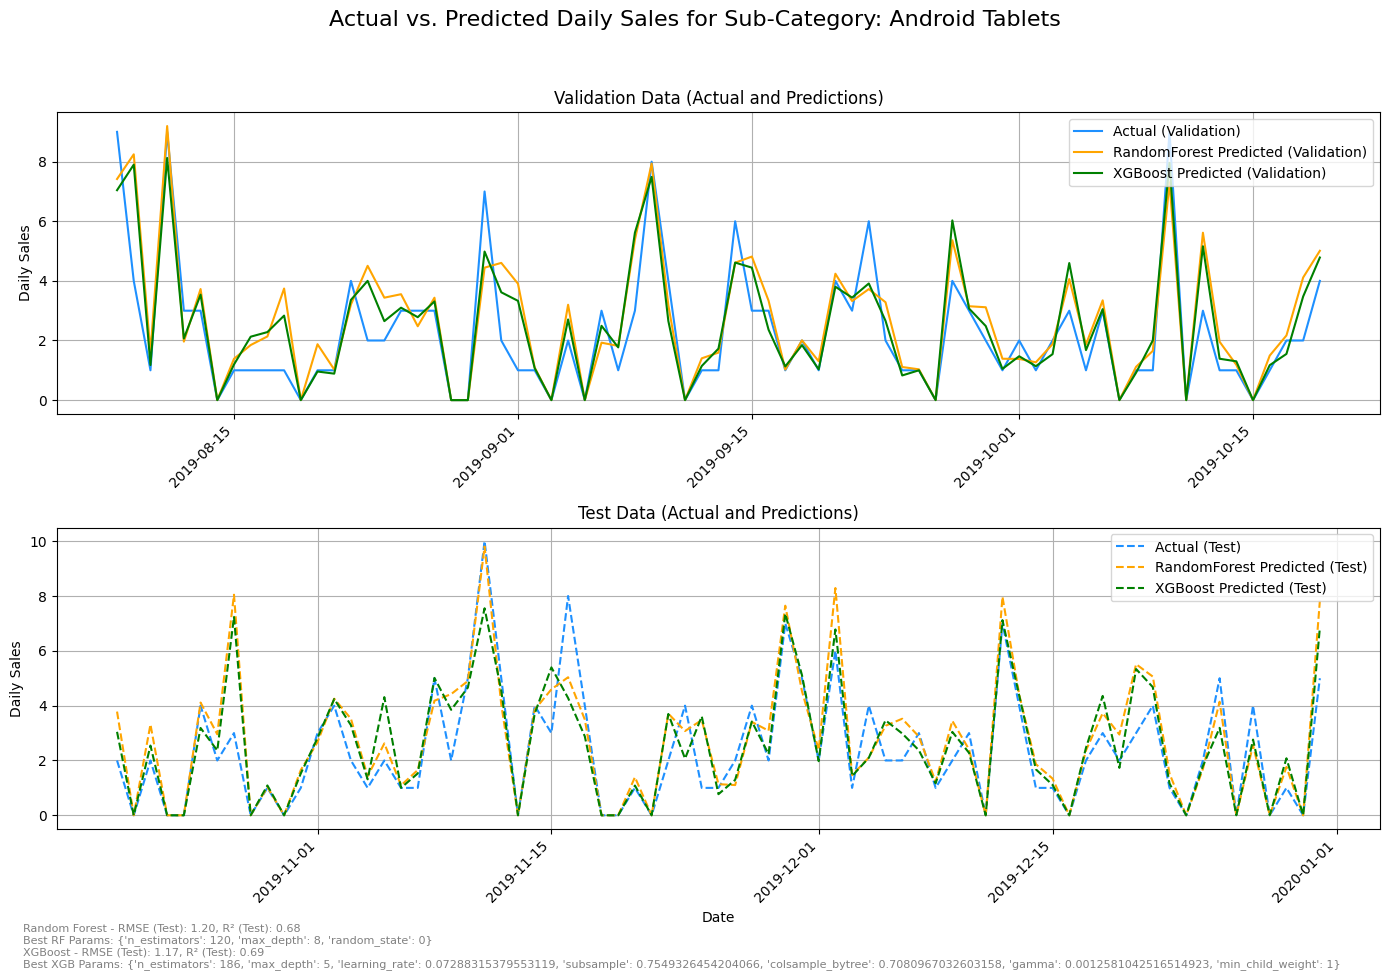

[I 2024-11-08 21:56:38,946] A new study created in memory with name: no-name-03d7df64-41a7-4f3a-9b71-14214586b637



Sub-Category: Occupational Attire


[I 2024-11-08 21:56:39,757] Trial 0 finished with value: 1.2270316722446426 and parameters: {'n_estimators': 77, 'max_depth': 9, 'learning_rate': 0.256780080904253, 'subsample': 0.7264939901312023, 'colsample_bytree': 0.7829826598645333, 'gamma': 0.014337539432806108, 'min_child_weight': 1}. Best is trial 0 with value: 1.2270316722446426.
[I 2024-11-08 21:56:40,098] Trial 1 finished with value: 1.0469424410896953 and parameters: {'n_estimators': 134, 'max_depth': 4, 'learning_rate': 0.19514696347026633, 'subsample': 0.9084742705153444, 'colsample_bytree': 0.7514992243626546, 'gamma': 0.002370377287482765, 'min_child_weight': 1}. Best is trial 1 with value: 1.0469424410896953.
[I 2024-11-08 21:56:40,486] Trial 2 finished with value: 1.1415370222636827 and parameters: {'n_estimators': 174, 'max_depth': 5, 'learning_rate': 0.10011292525122059, 'subsample': 0.9293807545858765, 'colsample_bytree': 0.7536850183777402, 'gamma': 0.00013962555512041095, 'min_child_weight': 6}. Best is trial 1 w

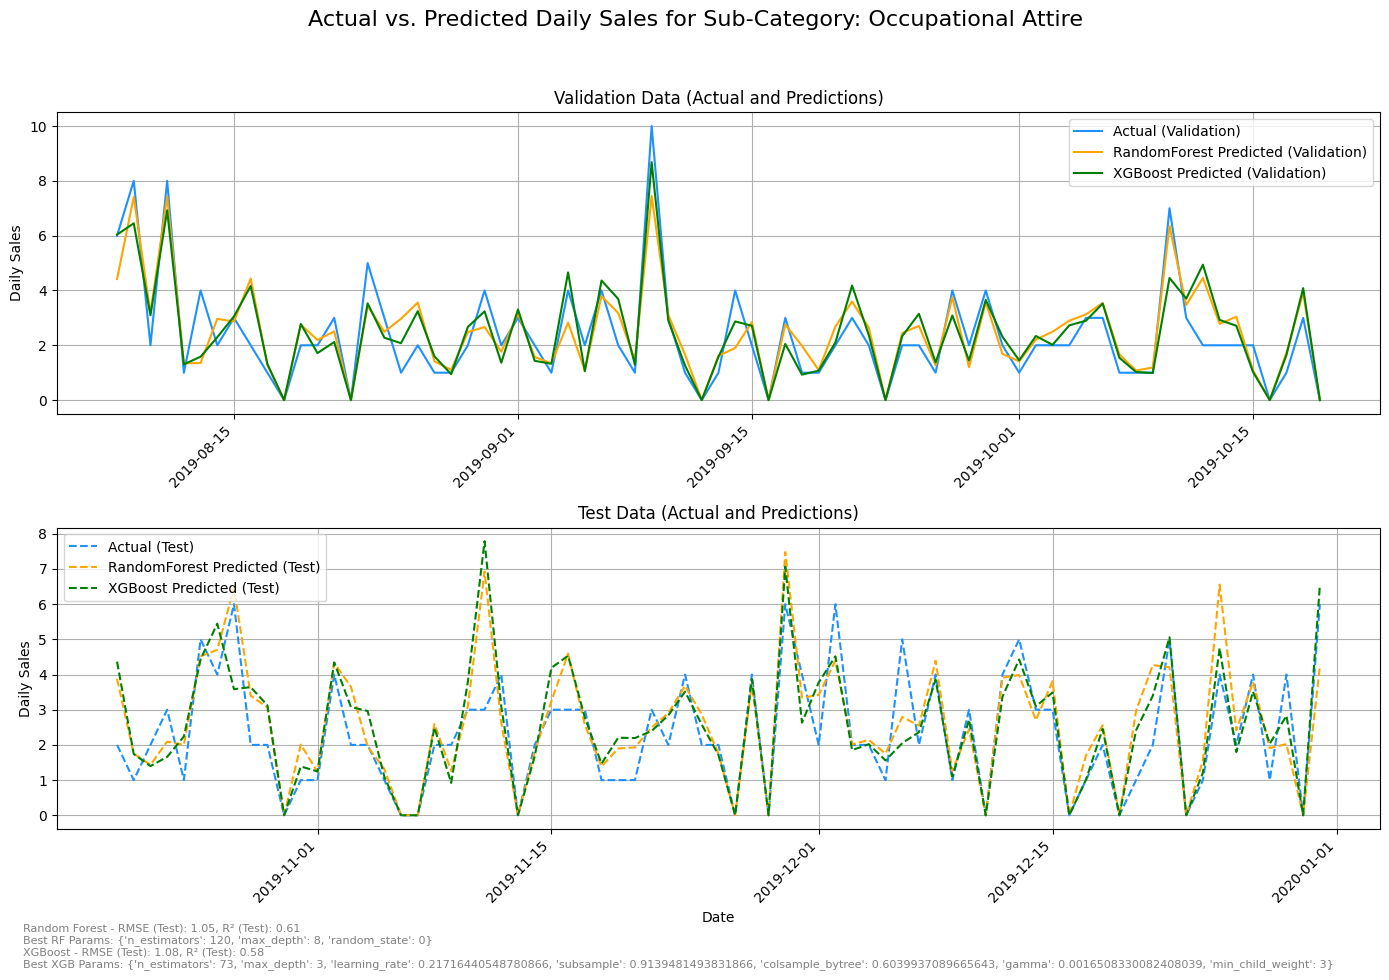

[I 2024-11-08 21:57:00,285] A new study created in memory with name: no-name-dd82d497-7397-493d-ac13-18514fd4584f



Sub-Category: Business & Casual Shirts


[I 2024-11-08 21:57:01,888] Trial 0 finished with value: 1.3694025319956145 and parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.18927516103610367, 'subsample': 0.7373494483727525, 'colsample_bytree': 0.8844447902358898, 'gamma': 0.015348823144054809, 'min_child_weight': 9}. Best is trial 0 with value: 1.3694025319956145.
[I 2024-11-08 21:57:02,570] Trial 1 finished with value: 0.9935702204696707 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.083996530881118, 'subsample': 0.6687920727196888, 'colsample_bytree': 0.9148065389509339, 'gamma': 0.0432179833163519, 'min_child_weight': 2}. Best is trial 1 with value: 0.9935702204696707.
[I 2024-11-08 21:57:02,955] Trial 2 finished with value: 1.300835948151336 and parameters: {'n_estimators': 148, 'max_depth': 8, 'learning_rate': 0.0527373249123939, 'subsample': 0.802262471293598, 'colsample_bytree': 0.802129565241402, 'gamma': 1.346635170320103e-05, 'min_child_weight': 9}. Best is trial 1 with va

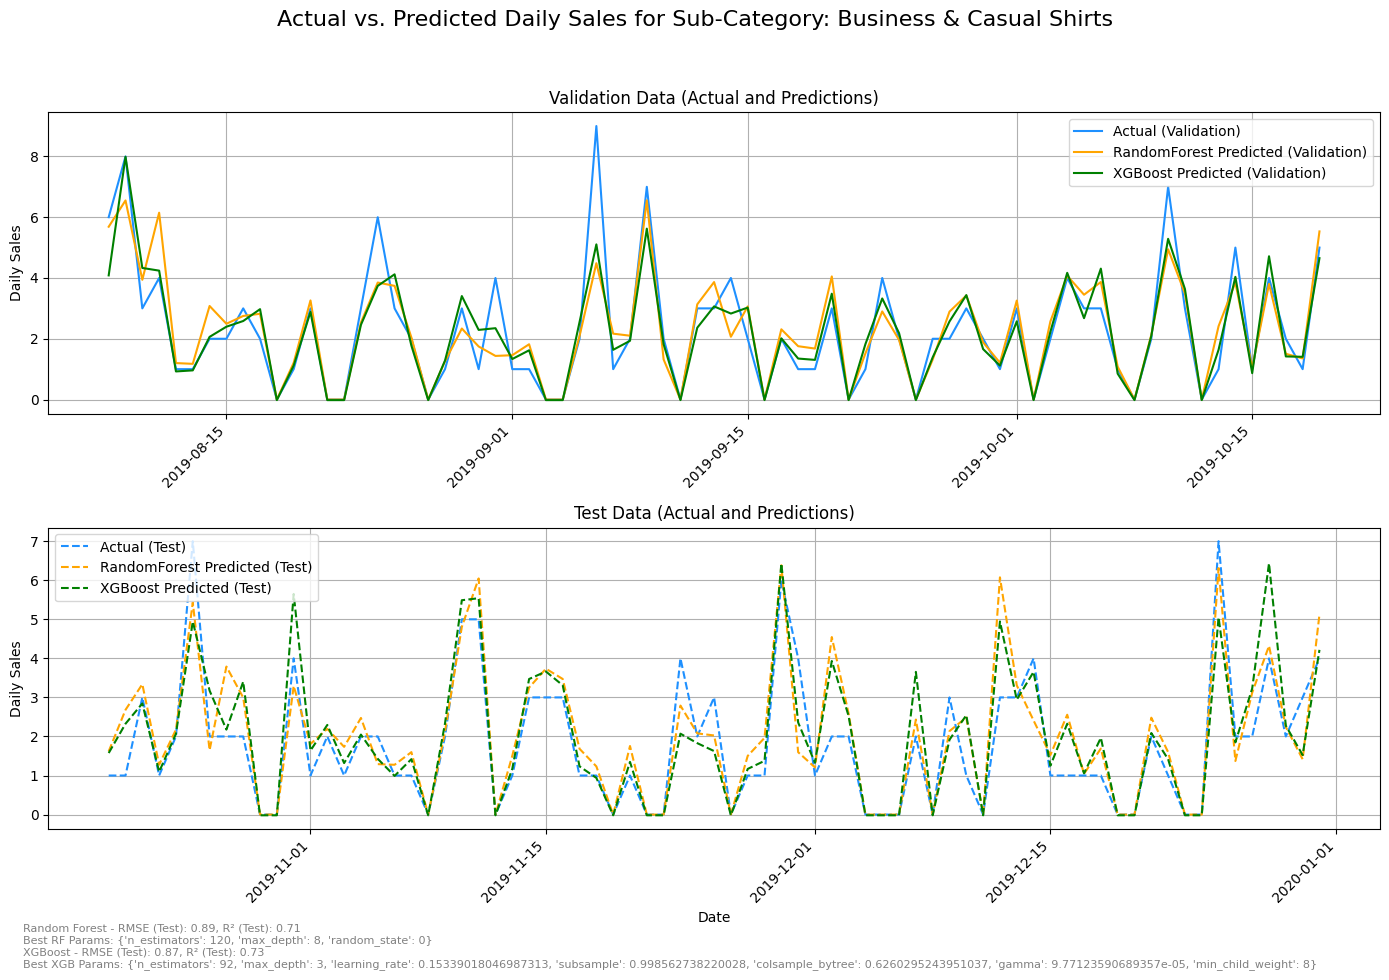

In [171]:
import optuna

# Function to optimize XGBoost parameters with Optuna
def objective(trial, X_train, y_train, X_valid, y_valid):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-5, 1e-1, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }
    model = XGBRegressor(**params, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    return mean_squared_error(y_valid, y_pred)

# Loop through each top sub-category
for sub_category in top_three:
    print(f"\nSub-Category: {sub_category}")

    # Filter data for the current sub-category and limit to January-October data
    sub_cat_df = daily_aggregated_df[(daily_aggregated_df['sub_category'] == sub_category) &
                                     (daily_aggregated_df['order_time'] < '2024-11-01')]

    # Define the features and target, and add 'order_time' for date-based indexing
    X = sub_cat_df[features]
    y = sub_cat_df['daily_sales']
    order_time = sub_cat_df['order_time']  # Keep the 'order_time' for plotting

    # Split data into training, validation, and test sets based on `order_time`
    X_train_full, X_test, y_train_full, y_test, train_time_full, test_time = train_test_split(
        X, y, order_time, test_size=0.2, shuffle=False)
    X_train, X_valid, y_train, y_valid, train_time, valid_time = train_test_split(
        X_train_full, y_train_full, train_time_full, test_size=0.25, shuffle=False)  # 60% train, 20% valid, 20% test

    # Optimize XGBoost parameters using Optuna
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X_train, y_train, X_valid, y_valid), n_trials=50)
    best_xgb_params = study.best_params

    # Define models with best hyperparameters from Optuna for XGBoost and predefined RF
    rf_params = {'n_estimators': 120, 'max_depth': 8, 'random_state': 0}
    models = {
        'RandomForest': RandomForestRegressor(**rf_params),
        'XGBoost': XGBRegressor(**best_xgb_params, random_state=0)
    }

    # Store predictions and metrics for each model
    predictions = {}
    metrics = {}
    for name, model in models.items():
        model.fit(X_train, y_train)

        # Predictions for validation and test
        y_valid_pred = model.predict(X_valid)
        y_test_pred = model.predict(X_test)
        predictions[name] = (y_valid_pred, y_test_pred)

        # Calculate metrics for validation and test
        metrics[name] = {
            'valid': {
                'r2': r2_score(y_valid, y_valid_pred),
                'rmse': np.sqrt(mean_squared_error(y_valid, y_valid_pred))
            },
            'test': {
                'r2': r2_score(y_test, y_test_pred),
                'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
            }
        }

    # Plotting
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle(f"Actual vs. Predicted Daily Sales for Sub-Category: {sub_category}", fontsize=16)

    # 1. Validation Data (Actual and Predictions)
    axes[0].plot(valid_time, y_valid, label="Actual (Validation)", color="dodgerblue")
    for name, (y_valid_pred, _) in predictions.items():
        color = "orange" if name == "RandomForest" else "green"
        axes[0].plot(valid_time, y_valid_pred, label=f"{name} Predicted (Validation)", color=color)
    axes[0].set_title("Validation Data (Actual and Predictions)")
    axes[0].set_ylabel("Daily Sales")
    axes[0].grid(True)
    axes[0].legend()

    # 2. Test Data (Actual and Predictions)
    axes[1].plot(test_time, y_test, label="Actual (Test)", color="dodgerblue", linestyle="--")
    for name, (_, y_test_pred) in predictions.items():
        color = "orange" if name == "RandomForest" else "green"
        axes[1].plot(test_time, y_test_pred, label=f"{name} Predicted (Test)", color=color, linestyle="--")
    axes[1].set_title("Test Data (Actual and Predictions)")
    axes[1].set_xlabel("Date")
    axes[1].set_ylabel("Daily Sales")
    axes[1].grid(True)
    axes[1].legend()

    # Add small text with R2, RMSE, and best hyperparameters for both models
    fig.text(
        0.02, 0.02,
        f"Random Forest - RMSE (Test): {metrics['RandomForest']['test']['rmse']:.2f}, R² (Test): {metrics['RandomForest']['test']['r2']:.2f}\n"
        f"Best RF Params: {rf_params}\n"
        f"XGBoost - RMSE (Test): {metrics['XGBoost']['test']['rmse']:.2f}, R² (Test): {metrics['XGBoost']['test']['r2']:.2f}\n"
        f"Best XGB Params: {best_xgb_params}",
        fontsize=8, color='gray', ha='left', va='bottom'
    )

    # Format x-axis to show dates as Year-Month-Day
    for ax in axes:
        ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()



Feature Importance for Sub-Category: Android Tablets


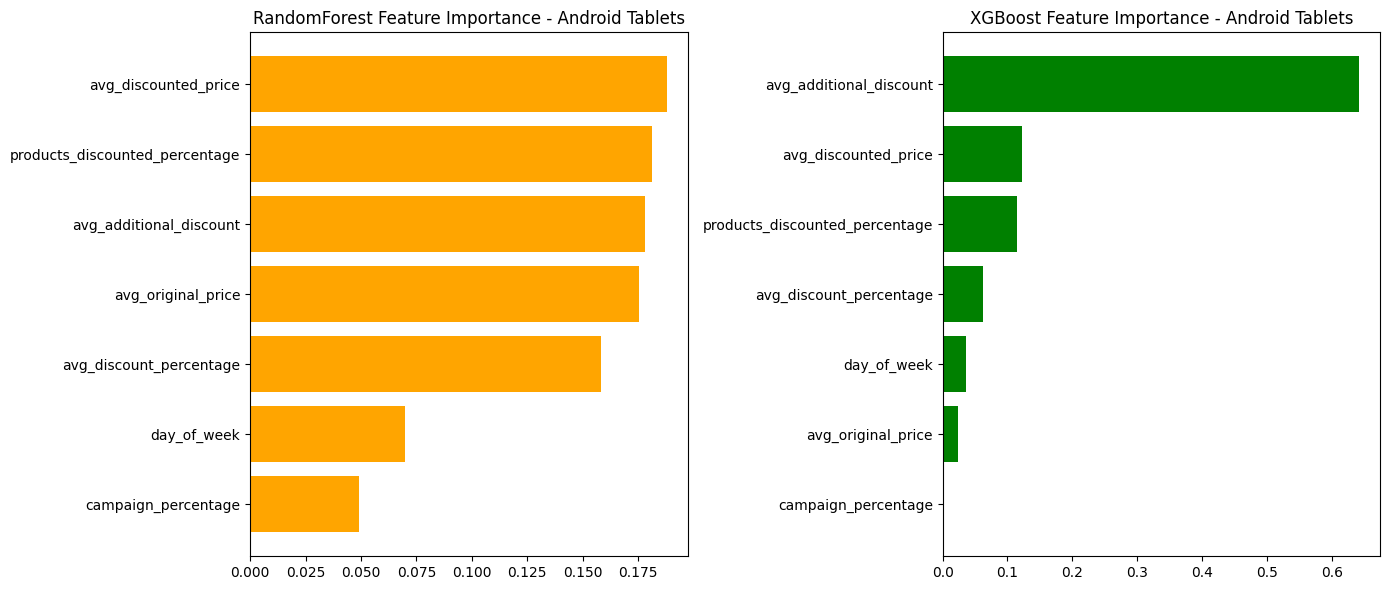


Feature Importance for Sub-Category: Occupational Attire


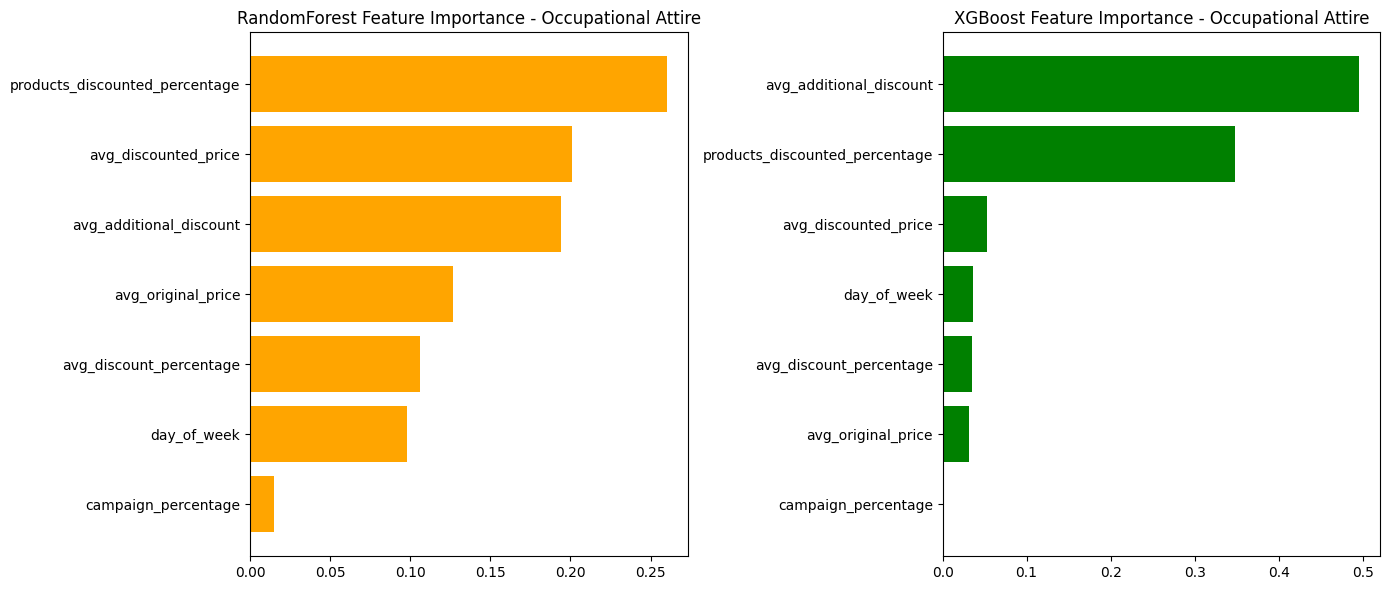


Feature Importance for Sub-Category: Business & Casual Shirts


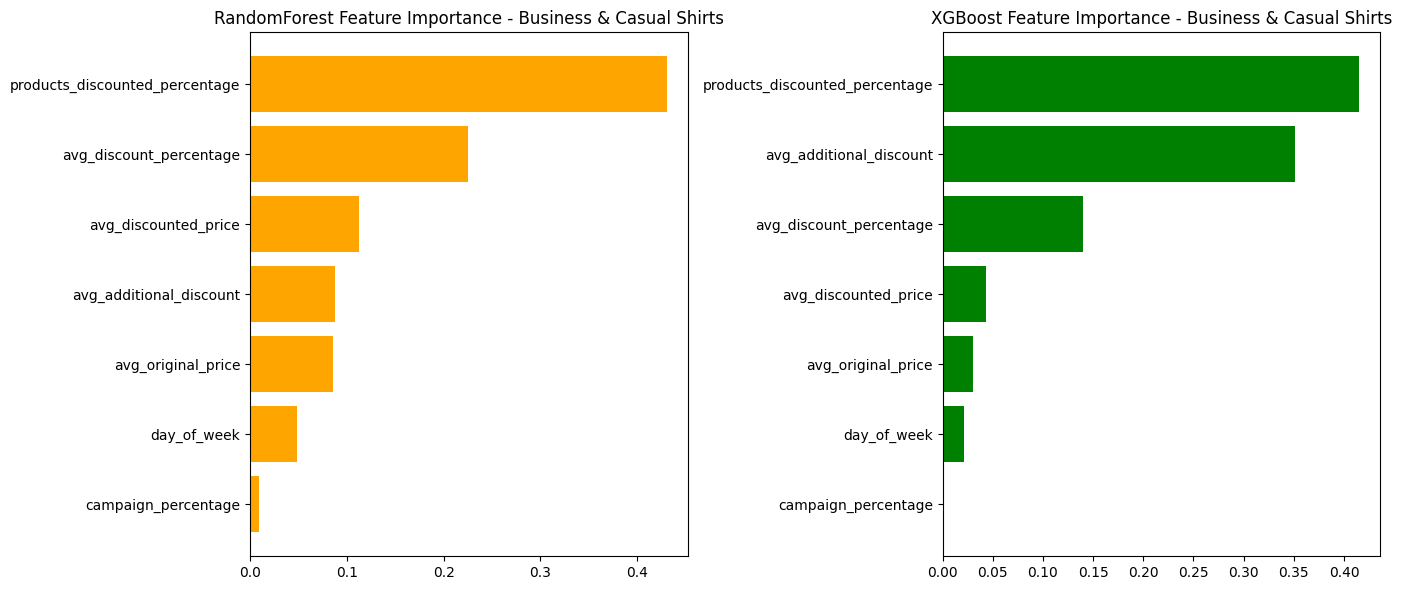

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Iterate over each sub-category
for sub_cat in top_three:
    print(f"\nFeature Importance for Sub-Category: {sub_cat}")

    # Filter data for the current sub-category
    sub_cat_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == sub_cat]

    # Define X and y
    X = sub_cat_df[features]
    y = sub_cat_df['daily_sales']

    # RandomForest Feature Importance
    rf_model = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_model.fit(X, y)
    rf_importances = rf_model.feature_importances_

    # XGBoost Feature Importance
    xgb_model = XGBRegressor(n_estimators=100, random_state=0)
    xgb_model.fit(X, y)
    xgb_importances = xgb_model.feature_importances_

    # Plotting Feature Importances
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))
    rf_sorted_idx = np.argsort(rf_importances)
    xgb_sorted_idx = np.argsort(xgb_importances)

    # RandomForest Feature Importance
    ax[0].barh(range(len(rf_sorted_idx)), rf_importances[rf_sorted_idx], color="orange")
    ax[0].set_yticks(range(len(rf_sorted_idx)))
    ax[0].set_yticklabels(np.array(features)[rf_sorted_idx])
    ax[0].set_title(f"RandomForest Feature Importance - {sub_cat}")

    # XGBoost Feature Importance
    ax[1].barh(range(len(xgb_sorted_idx)), xgb_importances[xgb_sorted_idx], color="green")
    ax[1].set_yticks(range(len(xgb_sorted_idx)))
    ax[1].set_yticklabels(np.array(features)[xgb_sorted_idx])
    ax[1].set_title(f"XGBoost Feature Importance - {sub_cat}")

    plt.tight_layout()
    plt.show()



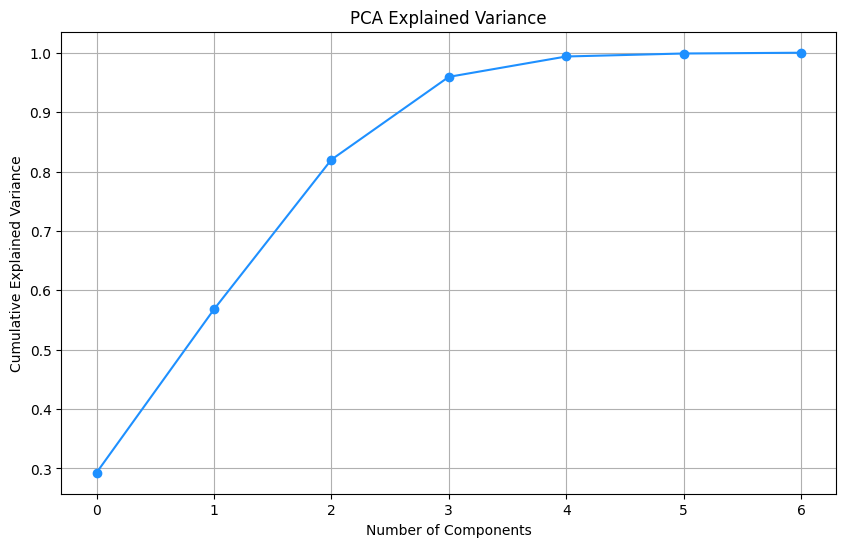

Top contributing features in the first few principal components:
                                     PC1       PC2       PC3       PC4  \
avg_original_price              0.396566  0.428290  0.408086  0.102925   
avg_discounted_price            0.462621  0.486667  0.214960  0.075623   
avg_additional_discount         0.518926 -0.479510 -0.019966  0.010094   
day_of_week                    -0.057564 -0.030454 -0.157801  0.985304   
products_discounted_percentage -0.169181 -0.236851  0.631855  0.080500   
campaign_percentage             0.521405 -0.476497 -0.021362  0.014706   
avg_discount_percentage        -0.235869 -0.256355  0.601882  0.077880   

                                     PC5  
avg_original_price             -0.128344  
avg_discounted_price            0.063702  
avg_additional_discount        -0.015202  
day_of_week                     0.004827  
products_discounted_percentage  0.713766  
campaign_percentage            -0.021543  
avg_discount_percentage        -0.685047 

In [173]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Impute missing values with median
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Standardizing the features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Applying PCA
pca = PCA(n_components=len(features))
X_pca = pca.fit_transform(X_scaled)

# Plotting the Explained Variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='dodgerblue')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid(True)
plt.show()

# PCA Component Loadings for each feature
pca_loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i+1}" for i in range(len(features))], index=features)

# Display top features in the first few principal components
print("Top contributing features in the first few principal components:")
print(pca_loadings.iloc[:, :5])  # Displaying first 5 principal components for readability


In [174]:
daily_aggregated_df.columns

Index(['sub_category', 'order_time', 'avg_original_price',
       'avg_discounted_price', 'avg_additional_discount', 'day_of_week',
       'is_weekend', 'products_discounted_percentage', 'campaign_percentage',
       'campaign', 'avg_discount_percentage', 'daily_sales'],
      dtype='object')

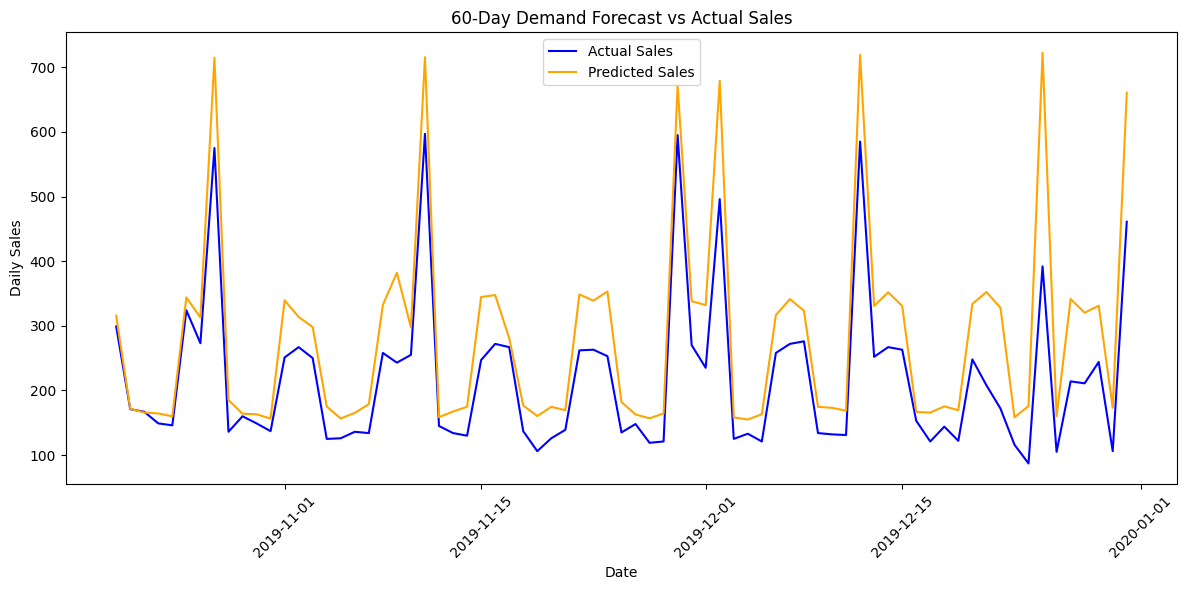

RMSE for the 60-Day Test Set: 83.42


In [178]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the target and features for training
all_features = [
    'avg_original_price',
       'avg_discounted_price', 'avg_additional_discount', 'day_of_week',
       'is_weekend', 'products_discounted_percentage', 'campaign_percentage', 'avg_discount_percentage'
]
aggregated_df = daily_aggregated_df.groupby('order_time').agg({
    'avg_original_price':'mean',
    'avg_discounted_price':'mean',
    'avg_additional_discount':'mean',
    'day_of_week': 'first',
    'is_weekend': 'first',
    'products_discounted_percentage': 'mean', 
    'campaign_percentage': 'mean',
    'avg_discount_percentage': 'mean',
    'daily_sales': 'sum'
}).reset_index()

# Add lagged features
aggregated_df['daily_sales_lag'] = aggregated_df['daily_sales'].shift(1)
aggregated_df['daily_sales_7day_avg'] = aggregated_df['daily_sales'].rolling(window=7, min_periods=1).mean().shift(1)

# Drop rows with NaN values resulting from lagged features
aggregated_df = aggregated_df.dropna().reset_index(drop=True)

# Define training and test data with a sequential 80-20 split
train_size = int(len(aggregated_df) * 0.8)
train_df, test_df = aggregated_df.iloc[:train_size], aggregated_df.iloc[train_size:]

# Define features and target
X_train = train_df[all_features]
y_train = train_df['daily_sales']
X_test = test_df[all_features]
y_test = test_df['daily_sales']

# Train the model on the training data
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
model.fit(X_train, y_train)

# Predict for the entire test set at once
predictions = model.predict(X_test)

# Plotting results
dates = test_df['order_time']  # Use dates corresponding to the test set
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual Sales', color='blue')
plt.plot(dates, predictions, label='Predicted Sales', color='orange')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title("60-Day Demand Forecast vs Actual Sales")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate RMSE for the test set
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE for the 60-Day Test Set: {rmse:.2f}")



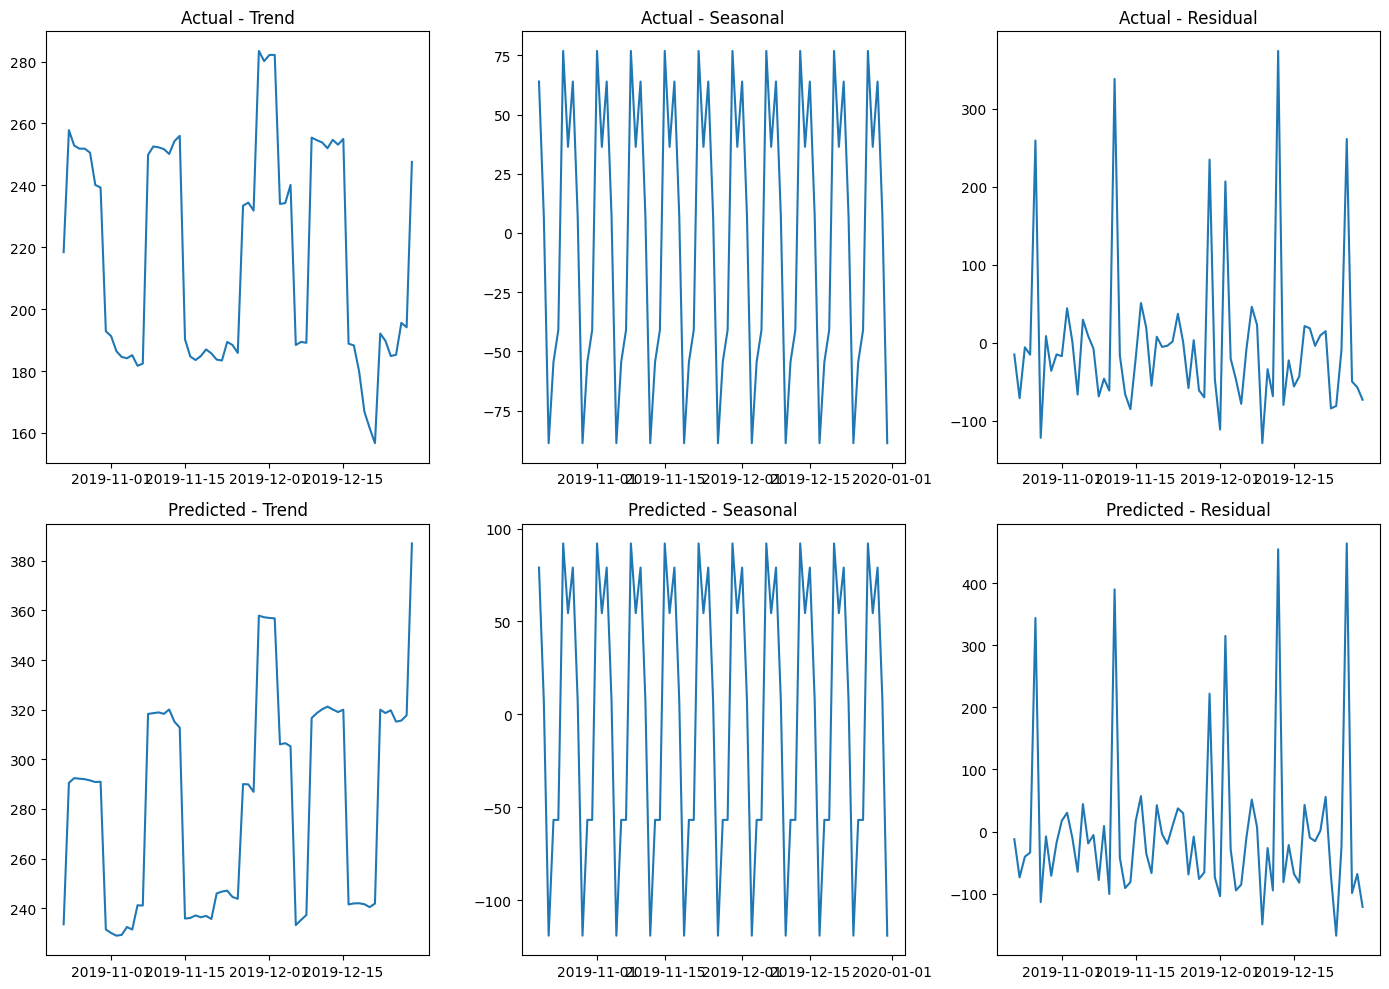

RMSE for the 60-Day Test Set: 83.42


In [179]:
# Drop rows with NaN values resulting from lagged features
aggregated_df = aggregated_df.dropna().reset_index(drop=True)

# Define training and test data with a sequential 80-20 split
train_size = int(len(aggregated_df) * 0.8)
train_df, test_df = aggregated_df.iloc[:train_size], aggregated_df.iloc[train_size:]

# Define features and target
X_train = train_df[all_features]
y_train = train_df['daily_sales']
X_test = test_df[all_features]
y_test = test_df['daily_sales']

# Train the model on the training data
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
model.fit(X_train, y_train)

# Predict for the entire test set at once
predictions = model.predict(X_test)

# Plotting the seasonal decomposition of actual vs predicted values
plt.figure(figsize=(14, 10))

# Decompose actual sales
actual_series = pd.Series(y_test.values, index=test_df['order_time'])
decomposition_actual = seasonal_decompose(actual_series, model='additive', period=7)

# Decompose predicted sales
predicted_series = pd.Series(predictions, index=test_df['order_time'])
decomposition_predicted = seasonal_decompose(predicted_series, model='additive', period=7)

# Plot actual sales decomposition
plt.subplot(2, 3, 1)
plt.plot(decomposition_actual.trend)
plt.title("Actual - Trend")

plt.subplot(2, 3, 2)
plt.plot(decomposition_actual.seasonal)
plt.title("Actual - Seasonal")

plt.subplot(2, 3, 3)
plt.plot(decomposition_actual.resid)
plt.title("Actual - Residual")

# Plot predicted sales decomposition
plt.subplot(2, 3, 4)
plt.plot(decomposition_predicted.trend)
plt.title("Predicted - Trend")

plt.subplot(2, 3, 5)
plt.plot(decomposition_predicted.seasonal)
plt.title("Predicted - Seasonal")

plt.subplot(2, 3, 6)
plt.plot(decomposition_predicted.resid)
plt.title("Predicted - Residual")

plt.tight_layout()
plt.show()

# Calculate RMSE for the test set
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE for the 60-Day Test Set: {rmse:.2f}")


Seasonal Component RMSE: 16.86
Seasonal Component MAE: 13.91


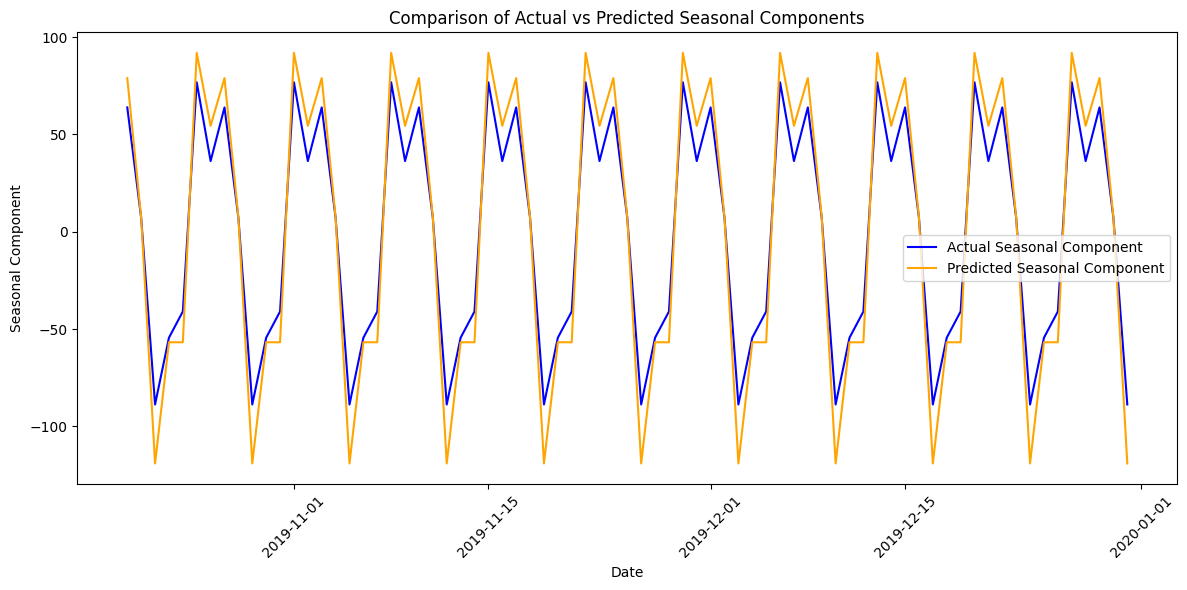

In [180]:

# Define training and test data with a sequential 80-20 split
train_size = int(len(aggregated_df) * 0.8)
train_df, test_df = aggregated_df.iloc[:train_size], aggregated_df.iloc[train_size:]

# Define features and target
X_train = train_df[all_features]
y_train = train_df['daily_sales']
X_test = test_df[all_features]
y_test = test_df['daily_sales']

# Train the model on the training data
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
model.fit(X_train, y_train)

# Predict for the entire test set at once
predictions = model.predict(X_test)

# Decompose actual and predicted sales
actual_series = pd.Series(y_test.values, index=test_df['order_time'])
decomposition_actual = seasonal_decompose(actual_series, model='additive', period=7)
predicted_series = pd.Series(predictions, index=test_df['order_time'])
decomposition_predicted = seasonal_decompose(predicted_series, model='additive', period=7)

# Extract seasonal components
seasonal_actual = decomposition_actual.seasonal
seasonal_predicted = decomposition_predicted.seasonal

# Calculate RMSE and MAE for seasonal component comparison
seasonal_rmse = np.sqrt(mean_squared_error(seasonal_actual, seasonal_predicted))
seasonal_mae = mean_absolute_error(seasonal_actual, seasonal_predicted)

print(f"Seasonal Component RMSE: {seasonal_rmse:.2f}")
print(f"Seasonal Component MAE: {seasonal_mae:.2f}")

# Plot comparison of seasonal components
plt.figure(figsize=(12, 6))
plt.plot(seasonal_actual, label='Actual Seasonal Component', color='blue')
plt.plot(seasonal_predicted, label='Predicted Seasonal Component', color='orange')
plt.xlabel('Date')
plt.ylabel('Seasonal Component')
plt.title("Comparison of Actual vs Predicted Seasonal Components")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Seasonal Component RMSE: 0.20
Seasonal Component MAE: 0.18


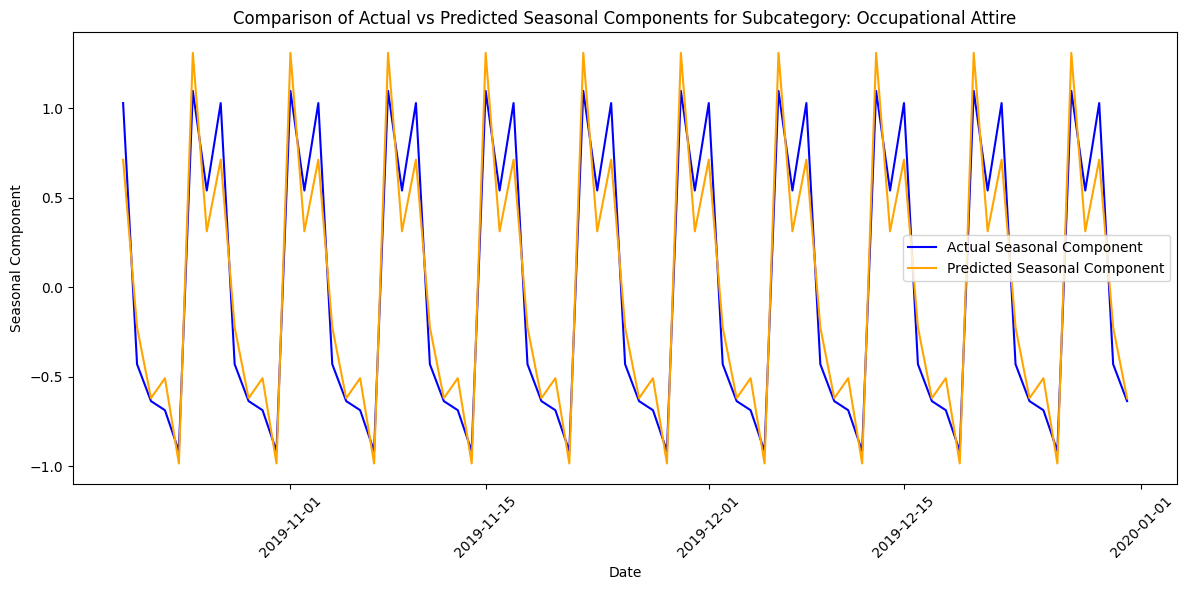

In [185]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filter data for the specific subcategory
subcategory = top_three[1]
aggregated_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == subcategory].copy()

# Add lagged features
aggregated_df['daily_sales_lag'] = aggregated_df['daily_sales'].shift(1)
aggregated_df['daily_sales_7day_avg'] = aggregated_df['daily_sales'].rolling(window=7, min_periods=1).mean().shift(1)

# Define training and test data with a sequential 80-20 split
train_size = int(len(aggregated_df) * 0.8)
train_df, test_df = aggregated_df.iloc[:train_size], aggregated_df.iloc[train_size:]

# Define features and target
X_train = train_df[all_features]
y_train = train_df['daily_sales']
X_test = test_df[all_features]
y_test = test_df['daily_sales']

# Train the model on the training data
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
model.fit(X_train, y_train)

# Predict for the entire test set at once
predictions = model.predict(X_test)

# Decompose actual and predicted sales
actual_series = pd.Series(y_test.values, index=test_df['order_time'])
decomposition_actual = seasonal_decompose(actual_series, model='additive', period=7)
predicted_series = pd.Series(predictions, index=test_df['order_time'])
decomposition_predicted = seasonal_decompose(predicted_series, model='additive', period=7)

# Extract seasonal components
seasonal_actual = decomposition_actual.seasonal
seasonal_predicted = decomposition_predicted.seasonal

# Calculate RMSE and MAE for seasonal component comparison
seasonal_rmse = np.sqrt(mean_squared_error(seasonal_actual, seasonal_predicted))
seasonal_mae = mean_absolute_error(seasonal_actual, seasonal_predicted)

print(f"Seasonal Component RMSE: {seasonal_rmse:.2f}")
print(f"Seasonal Component MAE: {seasonal_mae:.2f}")

# Plot comparison of seasonal components
plt.figure(figsize=(12, 6))
plt.plot(seasonal_actual, label='Actual Seasonal Component', color='blue')
plt.plot(seasonal_predicted, label='Predicted Seasonal Component', color='orange')
plt.xlabel('Date')
plt.ylabel('Seasonal Component')
plt.title(f"Comparison of Actual vs Predicted Seasonal Components for Subcategory: {subcategory}")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


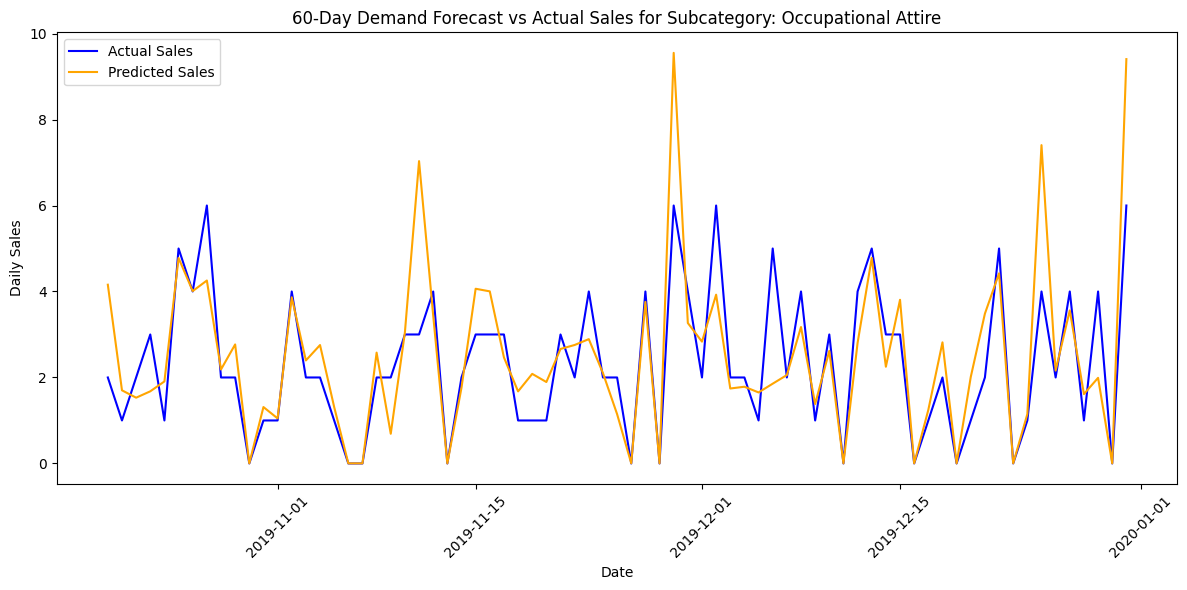

RMSE for the 60-Day Test Set for Subcategory 'Occupational Attire': 1.19


In [186]:

# Define training and test data with a sequential 80-20 split
train_size = int(len(aggregated_df) * 0.8)
train_df, test_df = aggregated_df.iloc[:train_size], aggregated_df.iloc[train_size:]

# Define features and target
X_train = train_df[all_features]
y_train = train_df['daily_sales']
X_test = test_df[all_features]
y_test = test_df['daily_sales']

# Train the model on the training data
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
model.fit(X_train, y_train)

# Predict for the entire test set at once
predictions = model.predict(X_test)

# Plotting results
dates = test_df['order_time']  # Use dates corresponding to the test set
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test, label='Actual Sales', color='blue')
plt.plot(dates, predictions, label='Predicted Sales', color='orange')
plt.xlabel('Date')
plt.ylabel('Daily Sales')
plt.title(f"60-Day Demand Forecast vs Actual Sales for Subcategory: {subcategory}")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate RMSE for the test set
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE for the 60-Day Test Set for Subcategory '{subcategory}': {rmse:.2f}")


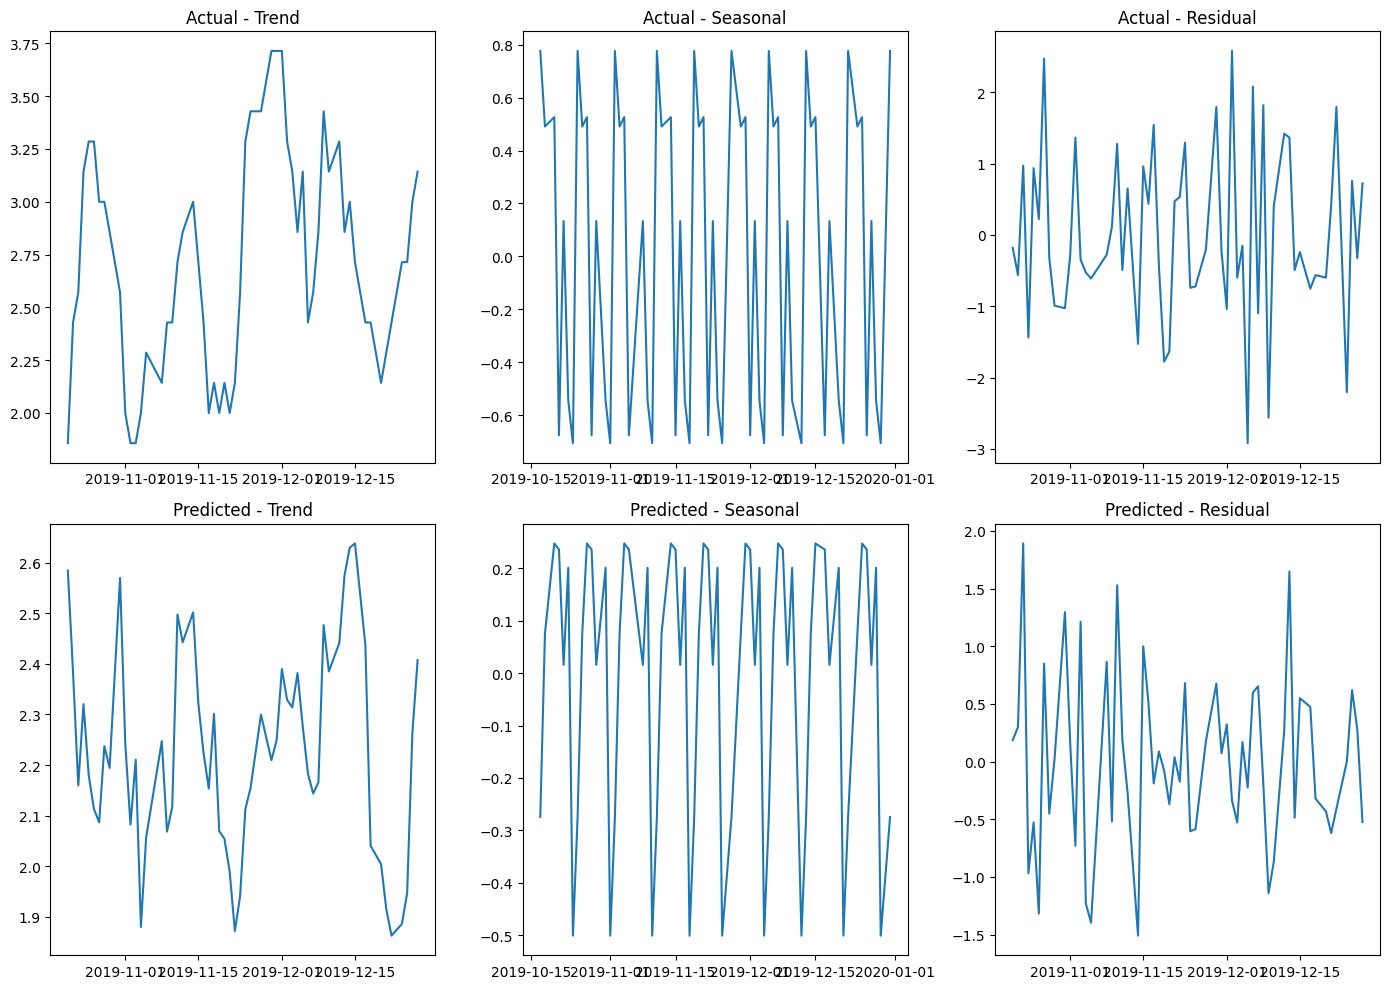

RMSE for the 60-Day Test Set for Subcategory 'Occupational Attire': 1.62


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filter data for the specific subcategory
subcategory = top_cats[1]
sub_cat_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == subcategory].copy()

# Define the target and features for training
all_features = [
    'day_of_week', 'is_weekend', 'month', 'avg_discount_percentage',
    'daily_sales_lag1', 'daily_sales_7day_avg'
]

# Group by `order_time` and prepare the aggregated dataframe for the subcategory
aggregated_df = sub_cat_df.groupby('order_time').agg({
    'day_of_week': 'first',
    'is_weekend': 'first',
    'month': 'first',
    'avg_discount_percentage': 'mean',
    'daily_sales': 'sum'
}).reset_index()

# Add lagged features
aggregated_df['daily_sales_lag1'] = aggregated_df['daily_sales'].shift(1)
aggregated_df['daily_sales_7day_avg'] = aggregated_df['daily_sales'].rolling(window=7, min_periods=1).mean().shift(1)

# Drop rows with NaN values resulting from lagged features
aggregated_df = aggregated_df.dropna().reset_index(drop=True)

# Define training and test data with a sequential 80-20 split
train_size = int(len(aggregated_df) * 0.8)
train_df, test_df = aggregated_df.iloc[:train_size], aggregated_df.iloc[train_size:]

# Define features and target
X_train = train_df[all_features]
y_train = train_df['daily_sales']
X_test = test_df[all_features]
y_test = test_df['daily_sales']

# Train the model on the training data
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=0)
model.fit(X_train, y_train)

# Predict for the entire test set at once
predictions = model.predict(X_test)

# Plotting the seasonal decomposition of actual vs predicted values
plt.figure(figsize=(14, 10))

# Decompose actual sales
actual_series = pd.Series(y_test.values, index=test_df['order_time'])
decomposition_actual = seasonal_decompose(actual_series, model='additive', period=7)

# Decompose predicted sales
predicted_series = pd.Series(predictions, index=test_df['order_time'])
decomposition_predicted = seasonal_decompose(predicted_series, model='additive', period=7)

# Plot actual sales decomposition
plt.subplot(2, 3, 1)
plt.plot(decomposition_actual.trend)
plt.title("Actual - Trend")

plt.subplot(2, 3, 2)
plt.plot(decomposition_actual.seasonal)
plt.title("Actual - Seasonal")

plt.subplot(2, 3, 3)
plt.plot(decomposition_actual.resid)
plt.title("Actual - Residual")

# Plot predicted sales decomposition
plt.subplot(2, 3, 4)
plt.plot(decomposition_predicted.trend)
plt.title("Predicted - Trend")

plt.subplot(2, 3, 5)
plt.plot(decomposition_predicted.seasonal)
plt.title("Predicted - Seasonal")

plt.subplot(2, 3, 6)
plt.plot(decomposition_predicted.resid)
plt.title("Predicted - Residual")

plt.tight_layout()
plt.show()

# Calculate RMSE for the test set
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE for the 60-Day Test Set for Subcategory '{subcategory}': {rmse:.2f}")


In [ ]:
# !{sys.executable} -m pip config set global.index-url https://pypi.org/simple
# !{sys.executable} -m pip install prophet

Writing to C:\Users\MuhammadFauzan\AppData\Roaming\pip\pip.ini
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/13.3 MB 1.4 MB/s eta 0:00:10
   -- ------------------------------------- 0.8/13.3 MB 1.6 MB/s eta 0:00:08
   --- ------------------------------------ 1.0/13.3 MB 1.3 MB/s eta 0:00:10
   --- ------------------------------------ 1.3/13.3 MB 1.3 MB/s eta 0:00:09
   ---- ----------------------------------- 1.6/13.3 MB 1.4 MB/s eta 0:00:09
   ----- ---------------------------------- 1.8/13.3 MB 1.5 MB/s eta 0:00:08
   ------ --------------------------------- 2.1/13.3 MB 1.4 MB/s eta 0:00:08
   ------- -------------------------------- 2.4/13.3 MB 1.4 MB/s eta 0:00:08
   -------- ------------------------------- 2.9/13.3 MB 1.5 MB/s eta 0:00:08
   --------- ------------------------------ 3.1/13.3 MB 1.5 MB/s eta 0:00:07
   ---------- -------------

In [195]:
from prophet import Prophet

22:51:31 - cmdstanpy - INFO - Chain [1] start processing
22:51:31 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 2.24
R-squared: -0.12


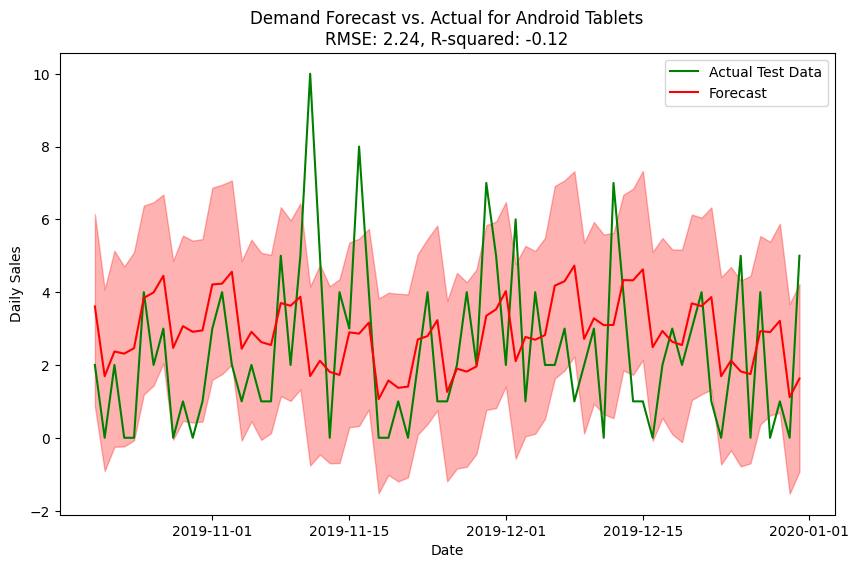

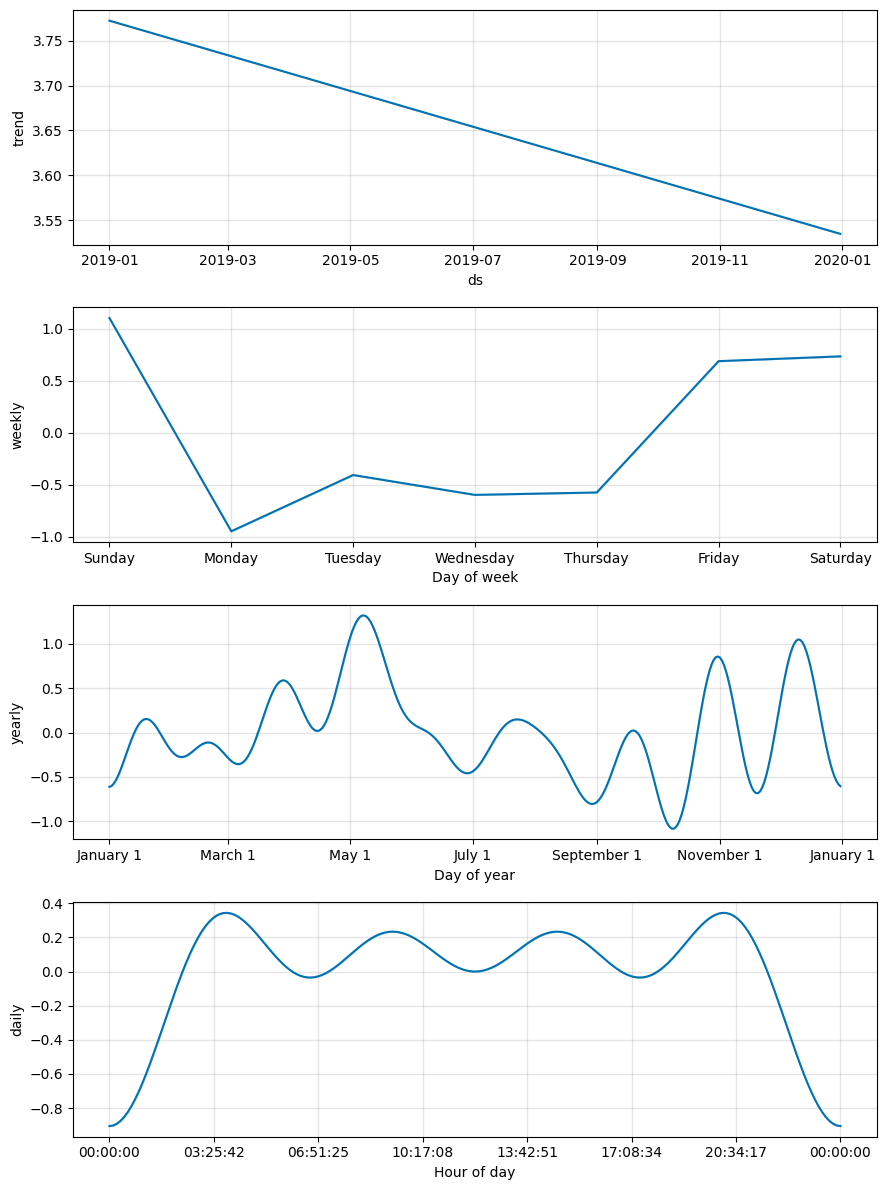

In [213]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Assuming `daily_aggregated_df` has a 'daily_sales' column and a date column 'order_time'
# and we're focusing on one sub-category, for example
sub_category = top_three[0]  # Replace with an actual sub-category name from top_three

# Filter the data for the chosen sub-category
sub_cat_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == sub_category].copy()

# Aggregate to get daily sales for forecasting
demand_data = sub_cat_df.resample('D', on='order_time')['daily_sales'].sum().reset_index()

# Rename columns to match Prophet requirements
demand_data.columns = ['ds', 'y']

# Split data into 80% train and 20% test
split_idx = int(len(demand_data) * 0.8)
train_data = demand_data.iloc[:split_idx]
test_data = demand_data.iloc[split_idx:]

# Initialize and fit the model on the train data
model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
model.fit(train_data)

# Create future dates for the length of the test data
future_dates = model.make_future_dataframe(periods=len(test_data), freq='D')

# Predict demand for the future dates
forecast = model.predict(future_dates)

# Calculate RMSE and R-squared between actual test data and forecast
y_true = test_data['y'].values
y_pred = forecast['yhat'][-len(test_data):].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r_squared = r2_score(y_true, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r_squared:.2f}")

# Plot the forecast with actual test data only for comparison
plt.figure(figsize=(10, 6))
plt.plot(test_data['ds'], test_data['y'], label="Actual Test Data", color='green')
plt.plot(forecast['ds'][-len(test_data):], forecast['yhat'][-len(test_data):], label="Forecast", color='red')
plt.fill_between(
    forecast['ds'][-len(test_data):], 
    forecast['yhat_lower'][-len(test_data):], 
    forecast['yhat_upper'][-len(test_data):], 
    color='red', 
    alpha=0.3
)
plt.title(f"Demand Forecast vs. Actual for {sub_category}\nRMSE: {rmse:.2f}, R-squared: {r_squared:.2f}")
plt.xlabel("Date")
plt.ylabel("Daily Sales")
plt.legend()
plt.show()

# Optional: Plot forecast components (trend, weekly, and yearly seasonality)
model.plot_components(forecast)
plt.show()


In [224]:
merged_df.product_id.value_counts()

product_id
8840     17
4652     16
19555    15
2346     14
17313    14
         ..
17019     1
19262     1
1868      1
17814     1
12548     1
Name: count, Length: 19439, dtype: int64

In [231]:
a = orders_df[orders_df.product_id == 8840]
a.sort_values(by='order_time', inplace=True)
a

C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_17556\3874417657.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a.sort_values(by='order_time', inplace=True)


order_id           order_time  product_id  customer_id  is_campaign  \
32129     32130  2019-01-22 15:46:00        8840          462        False   
72904     72905  2019-01-28 08:55:00        8840        73048        False   
53216     53217  2019-02-05 07:35:00        8840        35840         True   
75032     75033  2019-05-05 21:24:00        8840        54150         True   
37036     37037  2019-05-13 07:12:00        8840        78000        False   
43941     43942  2019-05-18 13:22:00        8840        80123        False   
62046     62047  2019-05-20 05:34:00        8840        43802        False   
28801     28802  2019-06-05 21:52:00        8840        73783         True   
58692     58693  2019-07-19 06:30:00        8840          713        False   
66798     66799  2019-07-25 07:19:00        8840        97229        False   
49486     49487  2019-08-22 22:15:00        8840        18839        False   
38037     38038  2019-09-09 21:58:00        8840        89991         True   
72677     72678  2019-09-27 15:25:00        8840        73048        False   
58072     58073  2019-11-02 23:04:00        8840          713        False   
75733     75734  2019-11-11 09:48:00        8840       109506         True   
15245     15246  2019-12-12 07:53:00        8840        20128         True   
38602     38603  2019-12-31 18:33:00        8840       108598         True   

       additional_discount                  campaign_name  
32129                  0.0                            NaN  
72904                  0.0                            NaN  
53216                 75.0      Other Seasonal Sales Date  
75032                 40.0     Additional Mega Sales Date  
37036                  0.0                            NaN  
43941                  0.0                            NaN  
62046                  0.0                            NaN  
28801                 50.0      Other Seasonal Sales Date  
58692                  0.0                            NaN  
66798                  0.0                            NaN  
49486                  0.0                            NaN  
38037                 40.0  High Priority Mega Sales Date  
72677                  0.0                            NaN  
58072                  0.0                            NaN  
75733                 20.0  High Priority Mega Sales Date  
15245                 35.0  High Priority Mega Sales Date  
38602                 50.0      Other Seasonal Sales Date

Selected Product: Samsung Galaxy Tab S7 FE 5G Tablet / Samsung Galaxy Tab S7 FE Wi-Fi Tablet | Shopee Malaysia


23:13:56 - cmdstanpy - INFO - Chain [1] start processing
23:13:56 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\MuhammadFauzan\AppData\Local\Temp\ipykernel_17556\1087547275.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_stock_levels = product_df['Stock'].resample('D').last().reindex(forecasted_demand['ds']).fillna(method='ffill')


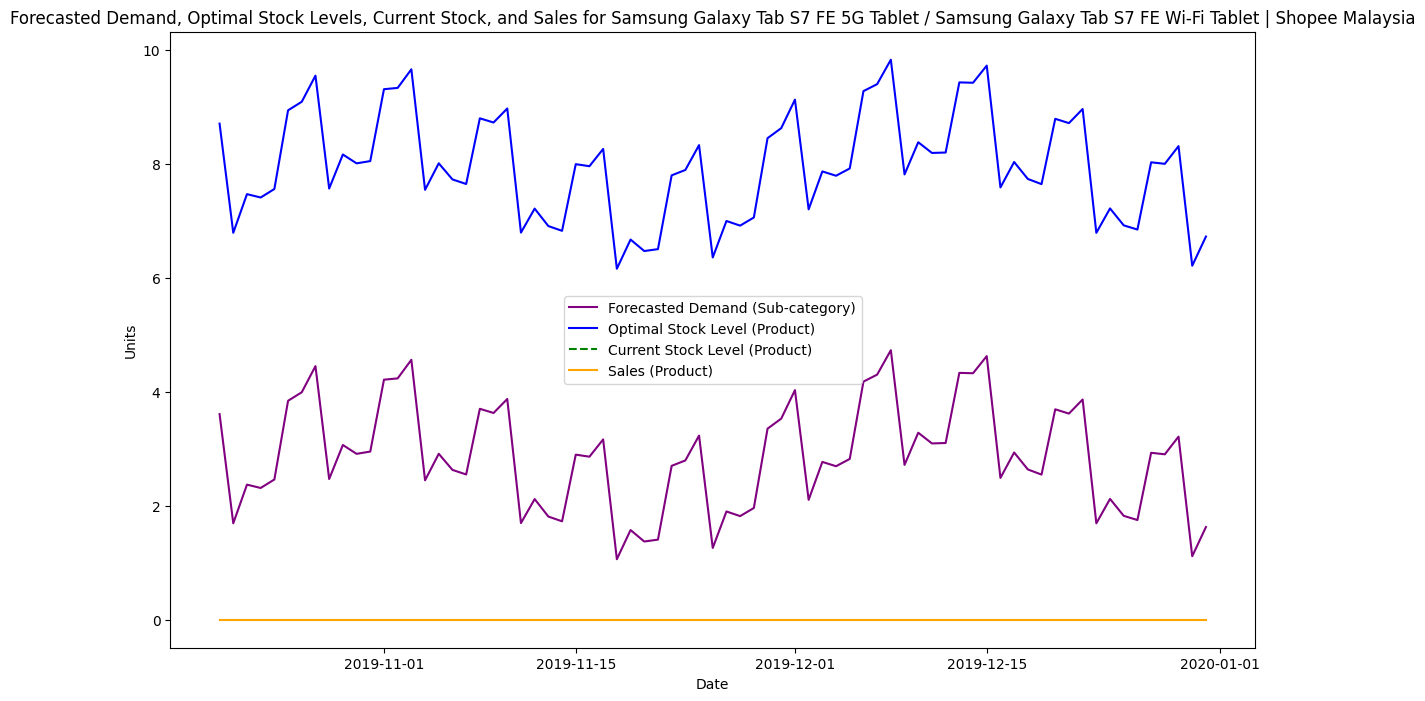

Summary for Samsung Galaxy Tab S7 FE 5G Tablet / Samsung Galaxy Tab S7 FE Wi-Fi Tablet | Shopee Malaysia:
Cost to Produce: 132.61513461312182
Holding Cost: 23.74671040873643
Lead Time: 1.7791 days
Safety Stock Level (for lead time coverage): 5.10


In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# Assuming `daily_aggregated_df`, `merged_df`, and `products_df` are available

# Product ID and sub-category setup
product_id = 8840
product_sample = products_df[products_df['product_id'] == product_id].iloc[0]
sub_category = product_sample['sub_category']

print(f"Selected Product: {product_sample['title']}")

# Extract relevant product details
cost_to_produce = product_sample['cost_to_produce']
holding_cost = product_sample['holding_cost']
lead_time = product_sample['lead_time']  # Assumes lead_time is in days

# 1. Forecast Demand for the Product Category
sub_cat_df = daily_aggregated_df[daily_aggregated_df['sub_category'] == sub_category].copy()
demand_data = sub_cat_df.resample('D', on='order_time')['daily_sales'].sum().reset_index()
demand_data.columns = ['ds', 'y']

# Split data into 80% train and 20% test
split_idx = int(len(demand_data) * 0.8)
train_data = demand_data.iloc[:split_idx]
test_data = demand_data.iloc[split_idx:]

# Fit a Prophet model to forecast demand
model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)
model.fit(train_data)

# Create future dates for the forecast period
future_dates = model.make_future_dataframe(periods=len(test_data), freq='D')
forecast = model.predict(future_dates)

# Get forecasted demand for the test period (last 20%)
forecasted_demand = forecast[['ds', 'yhat']].iloc[-len(test_data):].copy()
forecasted_demand['yhat'] = np.maximum(0, forecasted_demand['yhat'])  # Demand can't be negative

# 2. Current Stock Levels and Sales for Product ID 8840 from `merged_df`
# Ensure product_df has a DatetimeIndex on 'order_time'
product_df = merged_df[(merged_df['product_id'] == product_id) & 
                       (merged_df['order_time'].isin(forecasted_demand['ds']))].set_index('order_time')

# Calculate daily stock levels by taking the last known stock level for each day
daily_stock_levels = product_df['Stock'].resample('D').last().reindex(forecasted_demand['ds']).fillna(method='ffill')

# Calculate daily sales by counting the number of rows per day (each row represents a sale)
daily_sales = product_df.resample('D').size().reindex(forecasted_demand['ds']).fillna(0)

# Add current stock and sales to the forecasted demand DataFrame
forecasted_demand['current_stock_level'] = daily_stock_levels.values
forecasted_demand['daily_sales'] = daily_sales.values

# 3. Calculate Optimal Stock Levels
# Safety stock is calculated based on lead time to cover demand variations
safety_stock = lead_time * forecasted_demand['yhat'].mean()
forecasted_demand['optimal_stock_level'] = forecasted_demand['yhat'] + safety_stock

# Plot demand, optimal stock levels, current stock levels, and sales
plt.figure(figsize=(14, 8))

# Plot demand forecast for the sub-category
plt.plot(forecasted_demand['ds'], forecasted_demand['yhat'], label="Forecasted Demand (Sub-category)", color='purple')

# Plot optimal stock levels for the chosen product
plt.plot(forecasted_demand['ds'], forecasted_demand['optimal_stock_level'], label="Optimal Stock Level (Product)", color='blue')

# Plot current stock levels from merged_df
plt.plot(forecasted_demand['ds'], forecasted_demand['current_stock_level'], label="Current Stock Level (Product)", color='green', linestyle='--')

# Plot sales from merged_df
plt.plot(forecasted_demand['ds'], forecasted_demand['daily_sales'], label="Sales (Product)", color='orange')

# Set plot labels and title
plt.title(f"Forecasted Demand, Optimal Stock Levels, Current Stock, and Sales for {product_sample['title']}")
plt.xlabel("Date")
plt.ylabel("Units")
plt.legend()
plt.show()

# Print Summary
print(f"Summary for {product_sample['title']}:")
print(f"Cost to Produce: {cost_to_produce}")
print(f"Holding Cost: {holding_cost}")
print(f"Lead Time: {lead_time} days")
print(f"Safety Stock Level (for lead time coverage): {safety_stock:.2f}")
